# Loading Packages

In [1]:
import pyro.distributions as dist
import pyro.distributions.transforms as T
from pyro.nn import AutoRegressiveNN
from pyro.nn import ConditionalAutoRegressiveNN
import numpy as np
import torch, h5py, random, corner, pickle
from tqdm import tqdm
import copy, os

hist_settings = dict(
    bins = 40,
    histtype = 'step',
    lw = 3,
    density = True
)
########################Plotting Settings#########################
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
plt.style.use('dark_background')
########################GPU Availability#########################
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


# Load the the library data (v_2 should not be used for training!)

In [2]:
gwb_freq_bins = 5 ## How many freqs do you want (max is 30)

In [3]:
path_to_lib = '../Data/AstroData/sam_lib.hdf5'

In [4]:
with h5py.File(path_to_lib, 'r') as data:
    gwb_data = data['gwb'][()][:, 0:gwb_freq_bins, :]
    low_ind = np.where(gwb_data < 1e-20)
    gwb_data[low_ind] = 1e-20

    param_names = data.attrs['param_names'].astype(str)
    par_data = data['sample_params'][()]
    n_pars = par_data.shape[1]
n_real = gwb_data.shape[-1]
n_samp = gwb_data.shape[0]
par_data = np.broadcast_to(par_data, (n_real, n_samp, n_pars)).transpose((1, 2, 0))

print(f'The parameters are: {param_names}')

The parameters are: ['hard_time' 'gsmf_phi0' 'gsmf_mchar0_log10' 'mmb_mamp_log10'
 'mmb_scatter_dex' 'hard_gamma_inner']


## The params must be the same for any two realizations. Let's check that!

In [5]:
assert np.all(par_data[:, :, 100] == par_data[:, :, 89])

In [6]:
gwb_data.shape, par_data.shape

((2000, 5, 2000), (2000, 6, 2000))

## The first axis is samples, the second is realization

In [7]:
gwb_data = gwb_data.transpose((0, 2, 1))
par_data = par_data.transpose((0, 2, 1))
gwb_data.shape, par_data.shape

((2000, 2000, 5), (2000, 2000, 6))

## The third axis combines `gwb_freq` params with other `params`. This is just a matter of organization!

In [8]:
chain = np.concatenate((par_data, gwb_data), axis = 2)
chain.shape

(2000, 2000, 11)

## Some things that we need to know about the library...

In [9]:
Tspan = 505861299.1401643
freqs = np.arange(1/Tspan, (gwb_freq_bins + .001)/Tspan, 1/Tspan)
freqs

array([1.97682646e-09, 3.95365292e-09, 5.93047937e-09, 7.90730583e-09,
       9.88413229e-09])

## You need to take the log of `gwb_freq` params. They are easier to deal with this way.

In [10]:
chain[..., -gwb_freq_bins:] = 0.5 * np.log10(chain[..., -gwb_freq_bins:]**2/(12*np.pi**2 * freqs[None, None, :]**3 * Tspan))
chain.shape

(2000, 2000, 11)

## Perform manual linear transformation of all the parameters (gwb + astro) to `[-B = -5, B = 5]`. The specific choice of `B` should not matter.

In [11]:
B = 5
min = np.min(chain, axis = 0).min(axis = 0)
max = np.max(chain, axis = 0).max(axis = 0)
mean = (max + min) / 2
half_range = (max - min) / 2
chain = B * (chain - mean) / half_range

## The `chain` array needs to turn into a `pytorch` tensor object

In [17]:
from scipy.spatial import KDTree
import cloudpickle as cpl

In [18]:
tree = KDTree(chain[:, 0, :n_pars])
with open('../ChainPaper/ASTROSIM/kdtree.pkl', 'wb') as fout:
    cpl.dump(tree, fout)

In [20]:
chain = torch.tensor(chain, device = device, dtype=torch.float32)

In [23]:
chain.max()

tensor(5., device='cuda:0')

## The constants below need to be saved so you can convert from this new domain to the old domain

In [14]:
mean.shape, half_range.shape, chain.shape

((11,), (11,), torch.Size([2000, 2000, 11]))

# Construct the brain...

In [15]:
input_dim = gwb_freq_bins
count_bins = 32
context_dim = n_pars
hidden_dims = [128, 128]
param_dims = [count_bins, count_bins, count_bins - 1]

## Context params are the astro params

In [16]:
z = chain[random.randint(0, chain.shape[0] - 1), random.randint(0, chain.shape[1] - 1), 0:context_dim]
z

tensor([ 0.2368, -2.2444,  3.4940, -1.7184, -3.3124, -0.9049], device='cuda:0')

In [17]:
param_dist_base = dist.Uniform(torch.ones(n_pars, device = device) * (-B-1), 
                        torch.ones(n_pars, device = device) * (B+1))

param_hypernet = AutoRegressiveNN(input_dim = n_pars, 
                                  hidden_dims = [n_pars * 25, n_pars * 25], 
                                  param_dims=[16, 16, 16]).cuda()

param_transform = T.SplineAutoregressive(n_pars, 
                                                param_hypernet, 
                                                count_bins=16, 
                                                order = 'quadratic',
                                                bound = B+1).cuda()

param_flow_dist = dist.TransformedDistribution(param_dist_base,[param_transform])
z = param_flow_dist.sample(sample_shape=torch.Size([int(1e3)]))
z

tensor([[ 3.6871, -4.8118,  5.9780, -4.7753,  0.7759,  5.5388],
        [ 5.4907,  3.5124, -3.6707, -3.8338, -4.4953, -4.8260],
        [ 4.5110, -5.4905, -1.6773, -4.5103, -0.4167, -2.9549],
        ...,
        [-3.7838, -4.7711, -0.0877, -3.1890, -1.7329,  3.3647],
        [ 2.2661,  1.8193, -1.9154,  3.8590,  0.9484, -0.4272],
        [-2.5455,  5.5823, -4.1764,  3.5728,  5.4511,  3.1126]],
       device='cuda:0')

In [18]:
z.shape

torch.Size([1000, 6])

## We need to learn the GWB PSD params conditioned on the context params

In [19]:
rho_dist_base = dist.Uniform(torch.ones(input_dim, device = device) * (-B-1), 
                             torch.ones(input_dim, device = device) * ( B+1))

rho_hypernet = ConditionalAutoRegressiveNN(input_dim, 
                                         context_dim, 
                                         hidden_dims, 
                                         param_dims=param_dims).cuda()

rho_transform = T.ConditionalSplineAutoregressive(input_dim, 
                                                rho_hypernet, 
                                                count_bins=count_bins, 
                                                order = 'quadratic',
                                                bound = B+1).cuda()

rho_flow_dist = dist.ConditionalTransformedDistribution(rho_dist_base,[rho_transform])

rho_z = rho_flow_dist.condition(z).sample(sample_shape=torch.Size([int(1e3)]))
rho_z

tensor([[ 3.1942, -2.9985, -1.4804, -1.5330,  4.3501],
        [ 5.2674,  2.0323, -3.6773, -1.6240, -0.1981],
        [-2.1623, -2.6133, -3.3554, -2.0295,  4.5719],
        ...,
        [-2.2884,  2.9278, -1.4368, -3.7139,  0.1759],
        [-3.5802, -3.4536,  1.2301, -0.5349, -4.4666],
        [ 4.8397, -2.4714,  0.1192,  3.4306, -4.8329]], device='cuda:0')

## Choose your validation set: the other instance of the library

### Make Validation Set (from v_2 instance)

In [20]:
# val_size_percent = 20
# val_sample_idxs = random.sample(range(chain.shape[0]), k = int(val_size_percent/100 * chain.shape[0]))
# val_real_idxs = random.sample(range(chain.shape[0]), k = int(val_size_percent/100 * chain.shape[1]))
# val_chain = chain[np.ix_(val_sample_idxs, val_real_idxs)]
# torch.save(val_chain, 
#            f'../Data/AstroData/Paper/val_chain.pkl')
val_chain = torch.load(f'../Data/AstroData/Paper/val_chain.pkl')
val_chain.shape

/tmp/ipykernel_10048/2278628397.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  val_chain = torch.load(f'../Data/AstroData/Paper/val_chain.pkl')


torch.Size([400, 400, 11])

# Let it flow!

In [21]:
modules = torch.nn.ModuleList([rho_transform])
optimizer = torch.optim.Adam(modules.parameters(), lr=3e-3)

ct = 0
steps = 40001
loss_hist = []
val_loss_hist = []

total_sample_size = chain.shape[0]
total_real_size = chain.shape[1]
batch_size = int(1e2)
fail_counter = 0

for step in tqdm(range(steps)):
    # try:
    rand_sample = random.sample(range(total_sample_size), k = batch_size)
    rand_real = random.sample(range(total_sample_size), k = batch_size)

    optimizer.zero_grad()

    chosen_params = chain[rand_sample, 0 , 0:context_dim] ## env_params are all the same across realizations so `0` in the second axis can be anything!
    chosen_rhos = chain[rand_sample, rand_real , context_dim:]
    # chosen_rhos = train_chain[np.ix_(rand_sample, rand_real)][..., context_dim:]
    

    ln_p_rho_given_param = rho_flow_dist.condition(chosen_params).log_prob(chosen_rhos)
    
    loss = -(ln_p_rho_given_param).mean()

    if step % 200 == 0:

        ln_p_rho_given_param_val = rho_flow_dist.condition(val_chain[:, :, 0:context_dim]).log_prob(val_chain[:, :, context_dim:])
    
        val_loss = -(ln_p_rho_given_param_val).mean()
        
        loss.backward()
        val_loss.backward()
        optimizer.step()
        
        val_loss_hist.append(val_loss.item())
        loss_hist.append(loss.item())
        # print(f'loss at {loss_hist[ct]}')
        # print(f'validation at {val_loss_hist[ct]}')
        ct+=1
    else:
        loss.backward()
        optimizer.step()

    rho_flow_dist.clear_cache()
    # except:
    #     print('Failed!')
    #     fail_counter+=1
    #     rho_flow_dist.clear_cache()
    #     continue

    if step % 500 == 0 and step:
        torch.save([rho_flow_dist, half_range, B, mean, loss_hist, val_loss_hist], 
           f'../Data/AstroData/PaperFinal/condflow_at_{step}.pkl')

100%|██████████| 40001/40001 [18:33<00:00, 35.92it/s] 


## Save the flow

In [36]:
torch.save([rho_flow_dist, half_range, B, mean, loss_hist, val_loss_hist], 
           f'../Data/AstroData/PaperFinal/condflow_final.pkl')

# Postprocessing

### Plotting settings

In [23]:
labels = [r'$\log_{{{0}}}\rho_{{{1}}}$'.format(10, _+1) for _ in range(gwb_freq_bins)]

In [24]:
plt.style.use('default')
def figsize(scale, wc = 1, hc = 1):
    fig_width_pt = 513.17 #469.755                  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [wc * fig_width,hc * fig_height]
    return fig_size
plt.rcParams.update(plt.rcParamsDefault)

params = {#'backend': 'pdf',
        'axes.labelsize': 12,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        "xtick.top": True,
        "ytick.right": True,
        "xtick.minor.visible": True,
        "xtick.major.top": True, 
        "xtick.minor.top": True,
        "ytick.minor.visible": True, 
        "ytick.major.right": True, 
        "ytick.minor.right": True,
        "ytick.direction": "in",
        "xtick.direction": "in",
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        "text.usetex": True,
        #'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        'figure.figsize': figsize(0.5, 1, 1)}
plt.rcParams.update(params)

## Validation loss and training loss

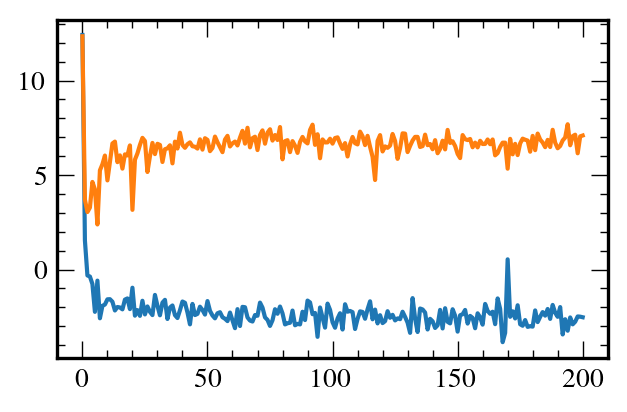

In [25]:
plt.plot(loss_hist)
plt.plot(val_loss_hist)
# plt.xlim(200, 1000)
# plt.yscale('symlog')
plt.show()

## Check 1: How well did it learn the data that was given to it

### Load the pickle if you do not have "live flow object"

In [26]:
# rho_flow_dist, half_range, B, mean, loss_hist, val_loss_hist = torch.load(f'../Data/AstroData/Paper/condflow_5_more.pkl', map_location = 'cuda')

### Choose a random set of astro params

In [27]:
rand_idx = random.randint(0, chain.shape[0] - 1)
# rand_idx = 91
rand_idx

1923

### Generate samples

In [28]:
chain_train = rho_flow_dist.condition(chain[rand_idx, 0, 0:context_dim]).sample((int(1e6),)).cpu().detach().numpy() \
* half_range[-gwb_freq_bins:]/B + mean[-gwb_freq_bins:]

### Samples from the library that was used for training

In [29]:
chain_reference = chain[rand_idx, :, -gwb_freq_bins:].cpu().detach().numpy() * half_range[-gwb_freq_bins:]/B + mean[-gwb_freq_bins:]

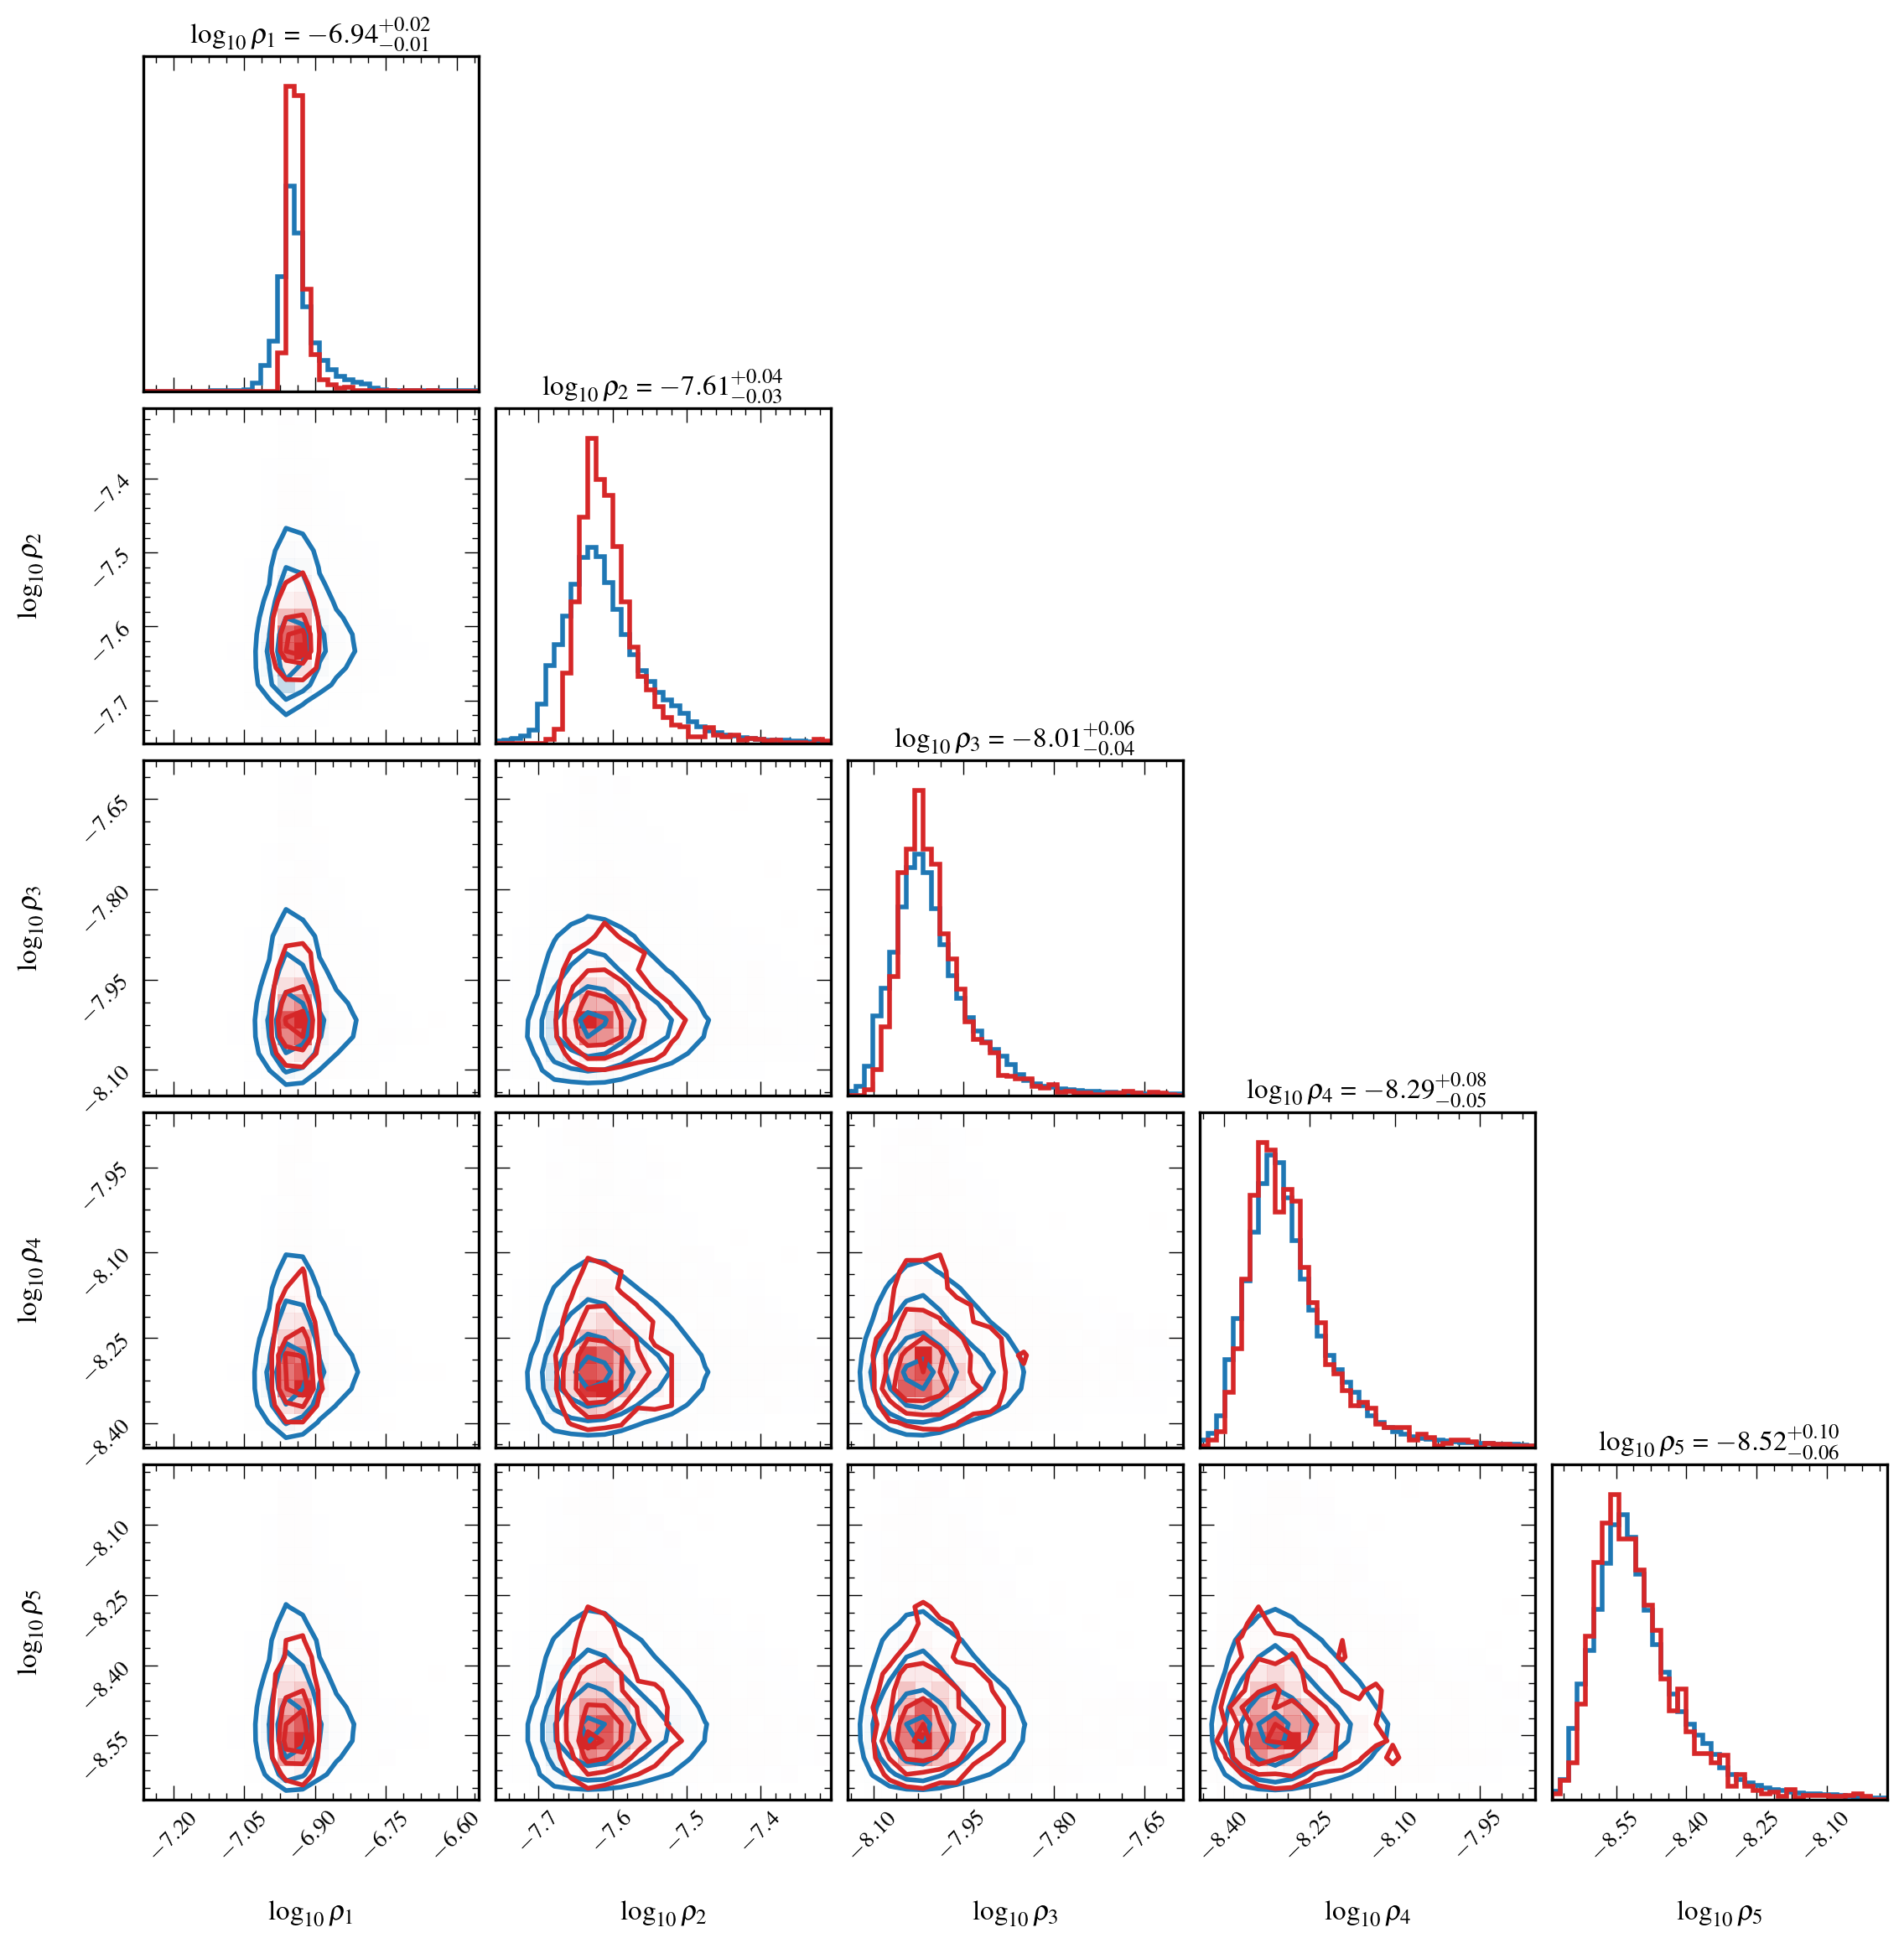

In [30]:
plt.close()

# ll = np.min(x, axis = 0)
# ul = np.max(x, axis = 0)
q = .01
ll = np.quantile(chain_train, q = q, axis = 0)
ul = np.quantile(chain_train, q = 1-q, axis = 0)
ranges = list(zip(ll, ul))
ranges

fig = None
fig = corner.corner(chain_train, color='C0', fig = fig, bins=20, hist_bin_factor=2, data_kwargs={'ms':3}, hist_kwargs={'density': True, 'lw':2}, 
                contour_kwargs={'linewidths':2}, show_titles = True, desity = True, plot_datapoints = False, range = ranges, labels = labels)

fig = corner.corner(chain_reference, fig = fig, color='C3', bins=20, hist_bin_factor=2, data_kwargs={'ms':3}, hist_kwargs={'density': True, 'lw':2}, 
                    contour_kwargs={'linewidths':2},  range = ranges, labels = labels,show_titles = True,
            truth_color = 'white', desity = True, plot_datapoints = False)

# plt.legend(handles=lg_lines, bbox_to_anchor=(0., 1.5, 1., .0), loc=4)
#plt.savefig('./Images/A4Cast/corner/5bins/corner_{}{}{}.png'.format(fidx, rr, pidx))
#plt.close()
plt.show()

## How about all of them?

In [31]:
chain_train = torch.zeros_like(chain)
chain_train[..., 0:context_dim] = chain[..., 0:context_dim]
for ct in range(chain.shape[0]):
    chain_train[ct, :, context_dim:] = rho_flow_dist.condition(chain_train[ct, 0, 0:context_dim]).sample((chain.shape[0],))
chain_train = chain_train.cpu().detach().numpy()
chain_train = chain_train* half_range/B + mean

In [32]:
chain_reference = chain.cpu().detach().numpy() * half_range/B + mean

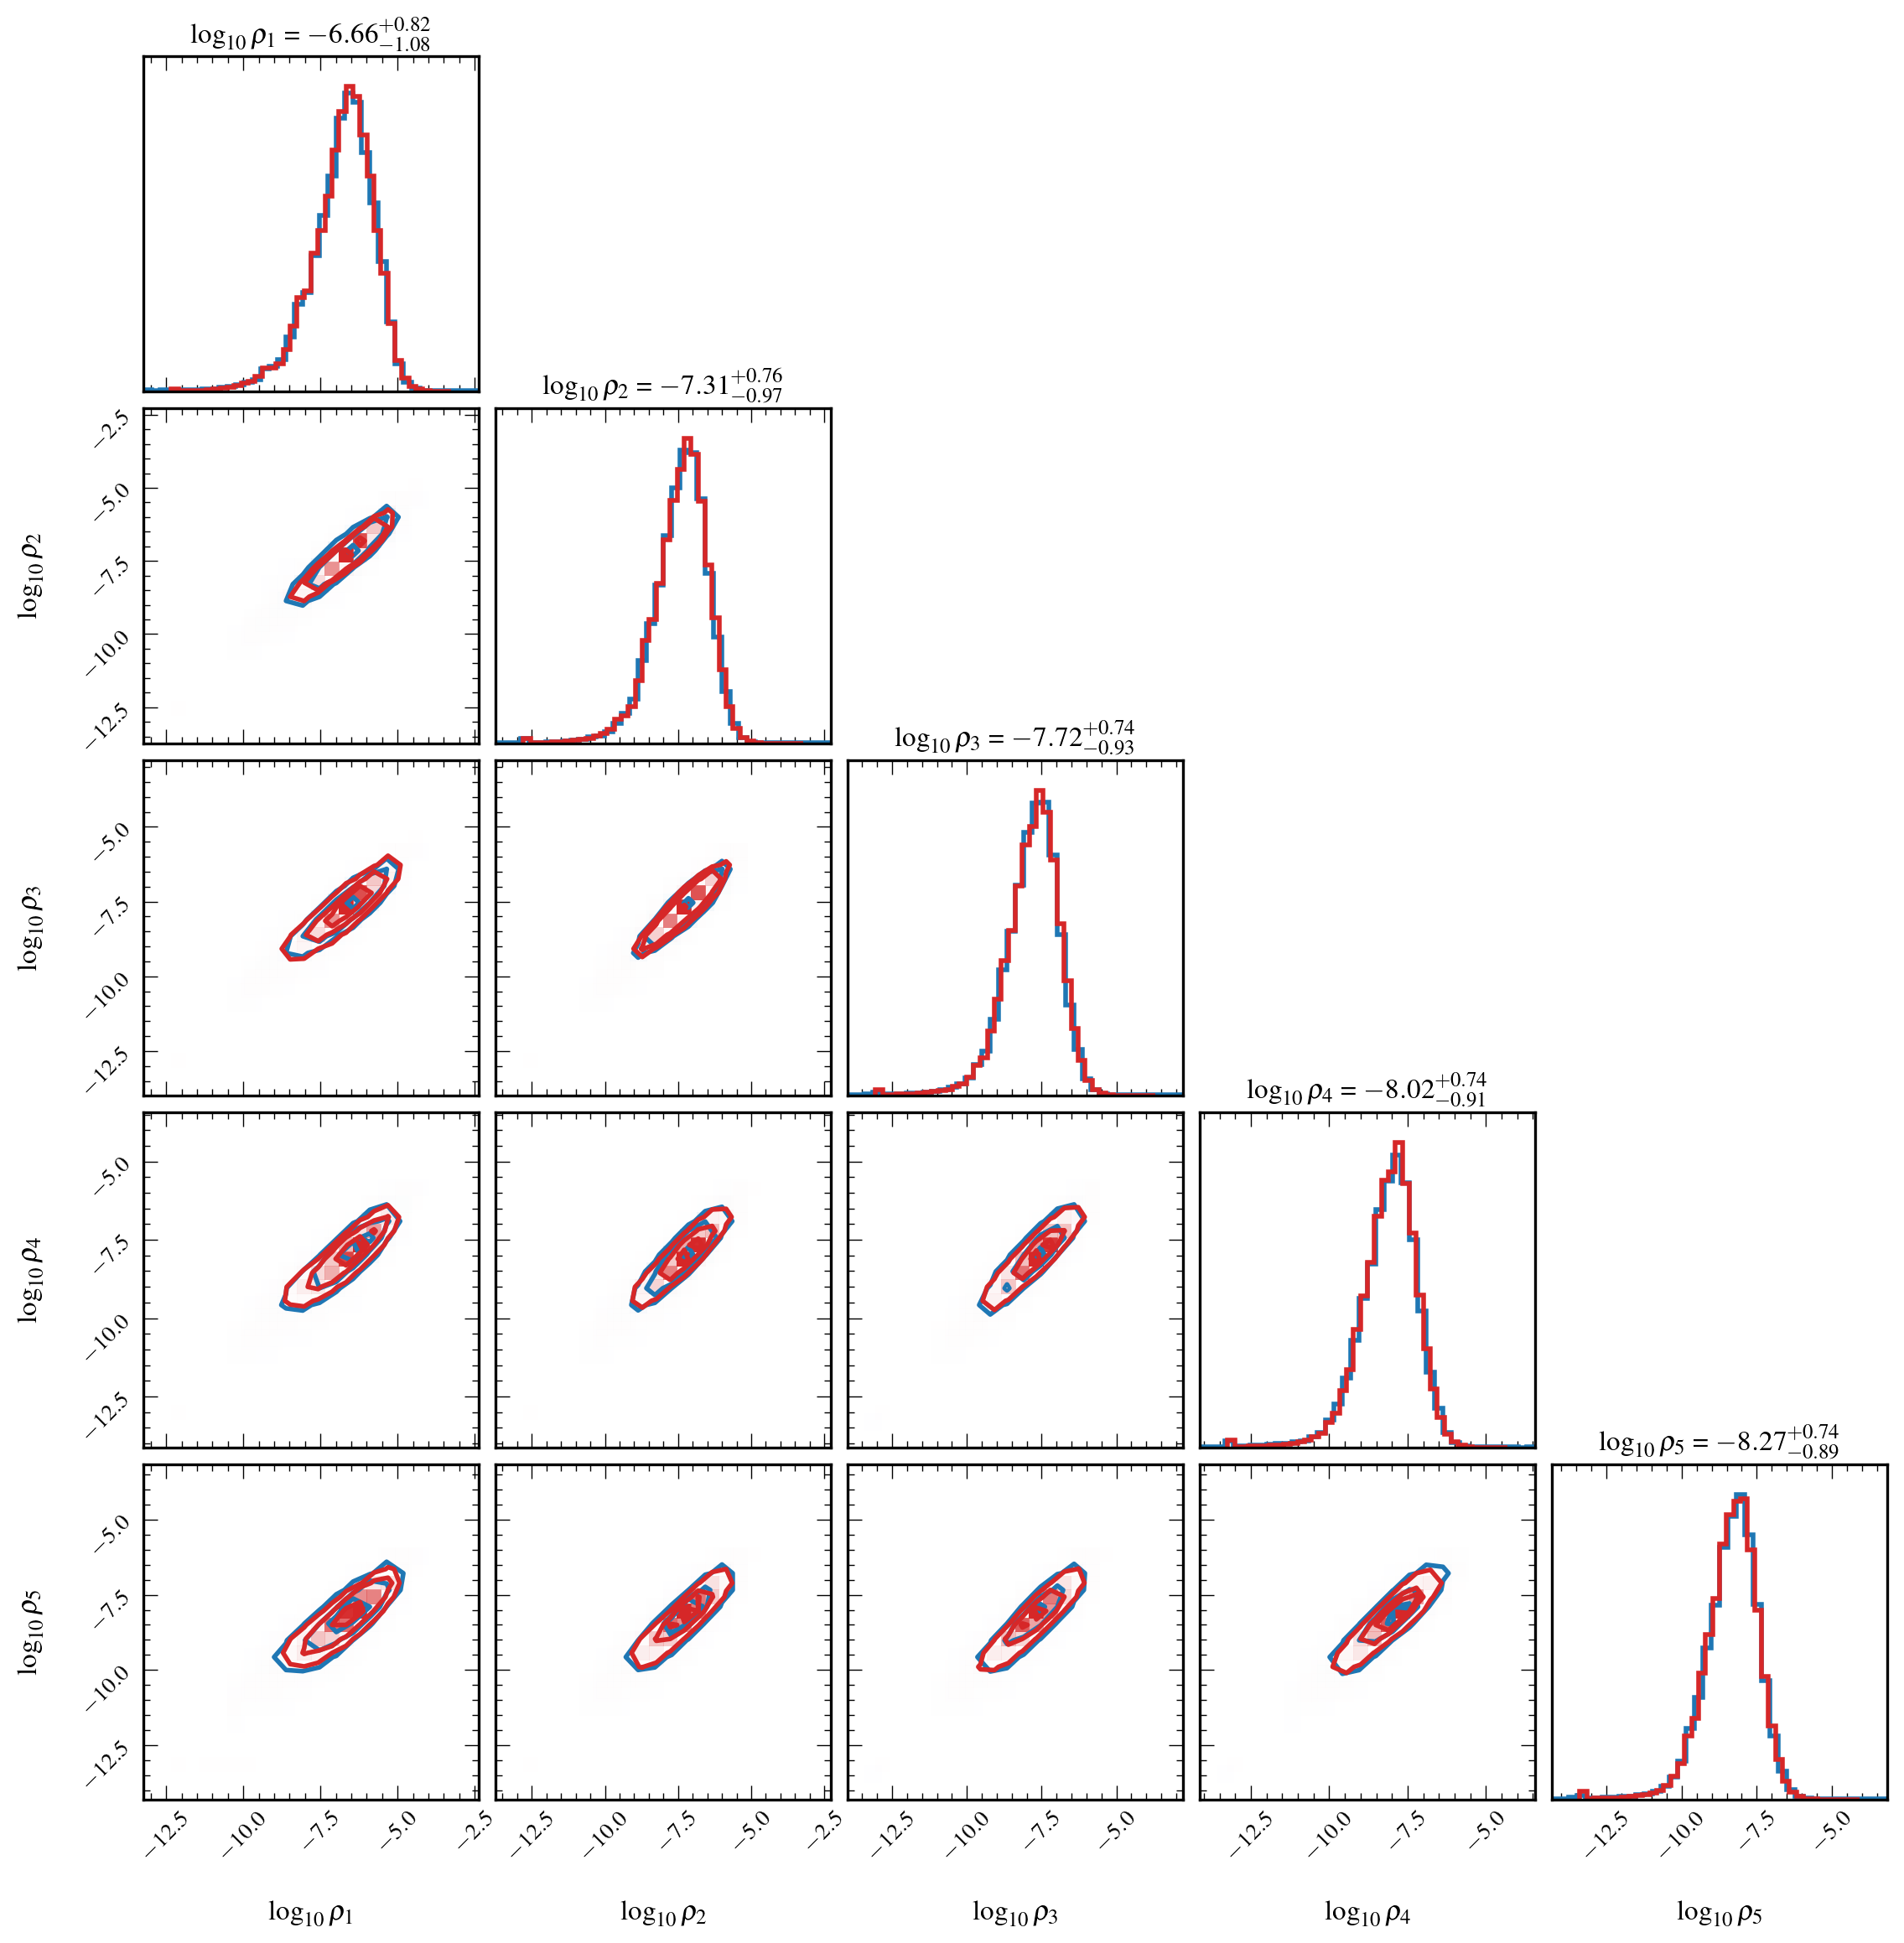

In [33]:
plt.close()
fig = None
fig = corner.corner(chain_train[:, :, -gwb_freq_bins:].reshape(chain.shape[0]*chain.shape[1], gwb_freq_bins), color='C0', 
              fig = fig, bins=20, hist_bin_factor=2, data_kwargs={'ms':3}, hist_kwargs={'density': True, 'lw':2}, 
                contour_kwargs={'linewidths':2}, show_titles = True, desity = True, plot_datapoints = False, ranges = ranges, labels = labels,)

fig = corner.corner(chain_reference[:, :, -gwb_freq_bins:].reshape(chain.shape[0]*chain.shape[1], gwb_freq_bins), color='C3', 
                    bins=20, hist_bin_factor=2, data_kwargs={'ms':3}, hist_kwargs={'density': True, 'lw':2}, fig = fig,
                    contour_kwargs={'linewidths':2}, show_titles = True, labels = labels,
            truth_color = 'white', desity = True, plot_datapoints = False)
# plt.legend(handles=lg_lines, bbox_to_anchor=(0., 1.5, 1., .0), loc=4)
#plt.savefig('./Images/A4Cast/corner/5bins/corner_{}{}{}.png'.format(fidx, rr, pidx))
#plt.close()
plt.show()

## Check 2: How well can it predict another library's content

In [5]:
crn_bins = gwb_freq_bins
n_pars = 6

In [6]:
path = '../Data/AstroData/sam_lib_v2.hdf5'
with h5py.File(path, 'r') as data:
    gwb_data = data['gwb'][()][:, 0:crn_bins, :]
    low_ind = np.where(gwb_data < 1e-20)
    gwb_data[low_ind] = 1e-20

    param_names = data.attrs['param_names'].astype(str)
    par_data = data['sample_params'][()]

n_real = gwb_data.shape[-1]
n_samp = gwb_data.shape[0]
par_data = np.broadcast_to(par_data, (n_real, n_samp, n_pars)).transpose((1, 2, 0))
gwb_data = gwb_data.transpose((0, 2, 1))
par_data = par_data.transpose((0, 2, 1))
chain = np.concatenate((par_data, gwb_data), axis = 2)
chain[..., -crn_bins:] = 0.5 * np.log10(chain[..., -crn_bins:]**2/(12*np.pi**2 * freqs[None, None, :]**3 * Tspan))

chain = B * (chain - mean) / half_range
chain = torch.tensor(chain, device = device, dtype=torch.float32)

NameError: name 'freqs' is not defined

In [28]:
chain_train = torch.zeros_like(chain)
chain_train[..., 0:context_dim] = chain[..., 0:context_dim]#param_flow_dist.sample((chain.shape[0],))
for ct in range(chain.shape[0]):
    chain_train[ct, :, context_dim:] = rho_flow_dist.condition(chain_train[ct, 0, 0:context_dim]).sample((chain.shape[0],))

### Choose a random set of astro params

In [29]:
# rand_idx = random.randint(0, chain.shape[0] - 1)
rand_idx = 1313
rand_idx

1313

### Generate samples

In [30]:
chain_train = rho_flow_dist.condition(chain[rand_idx, 0, 0:context_dim]).sample((int(1e6),)).cpu().detach().numpy() \
* half_range[-gwb_freq_bins:]/B + mean[-gwb_freq_bins:]

### Samples from the library that was used for training

In [31]:
chain_reference = chain[rand_idx, :, -gwb_freq_bins:].cpu().detach().numpy() * half_range[-gwb_freq_bins:]/B + mean[-gwb_freq_bins:]

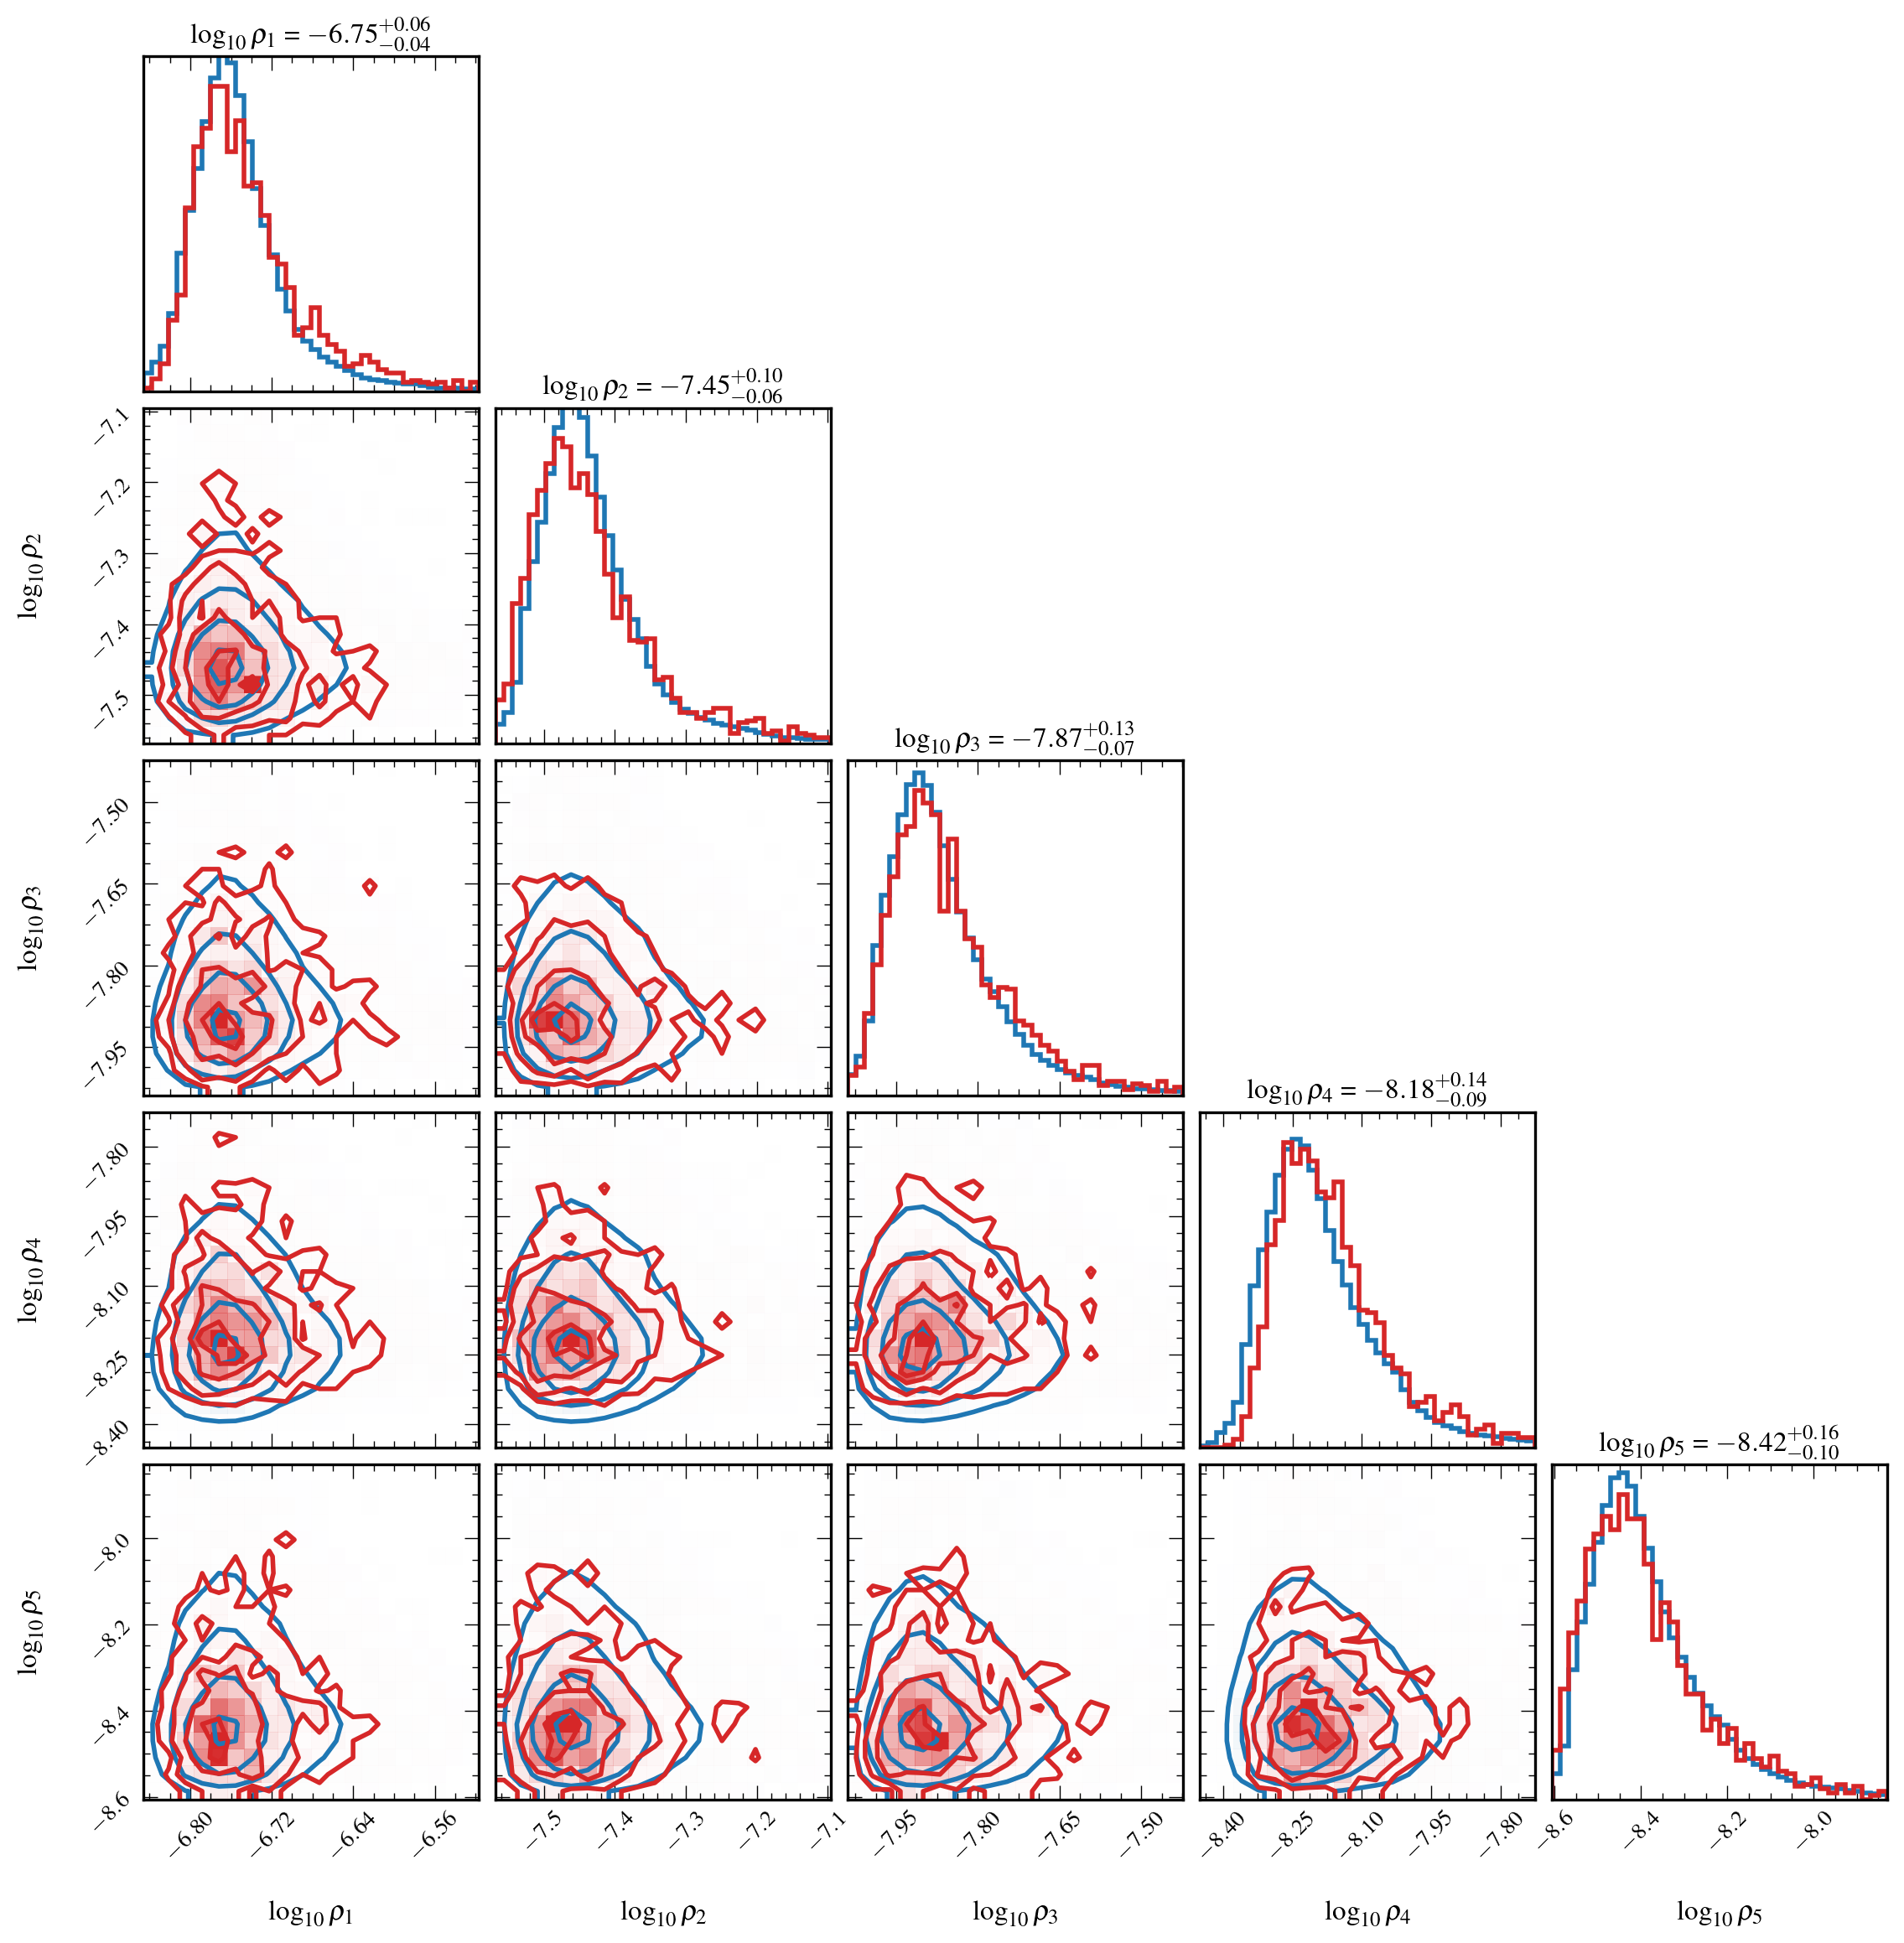

In [35]:
plt.close()

# ll = np.min(x, axis = 0)
# ul = np.max(x, axis = 0)
q = .02
ll = np.quantile(chain_train, q = q, axis = 0)
ul = np.quantile(chain_train, q = 1-q, axis = 0)
ranges = list(zip(ll, ul))
ranges

fig = None
fig = corner.corner(chain_train, color='C0', fig = fig, bins=20, hist_bin_factor=2, data_kwargs={'ms':3}, hist_kwargs={'density': True, 'lw':2}, 
                contour_kwargs={'linewidths':2}, show_titles = True, desity = True, plot_datapoints = False, range = ranges, labels = labels)

fig = corner.corner(chain_reference, fig = fig, color='C3', bins=20, hist_bin_factor=2, data_kwargs={'ms':3}, hist_kwargs={'density': True, 'lw':2}, 
                    contour_kwargs={'linewidths':2},  range = ranges, labels = labels,show_titles = True,
            truth_color = 'white', desity = True, plot_datapoints = False)

# plt.legend(handles=lg_lines, bbox_to_anchor=(0., 1.5, 1., .0), loc=4)
#plt.savefig('./Images/A4Cast/corner/5bins/corner_{}{}{}.png'.format(fidx, rr, pidx))
#plt.close()
plt.show()

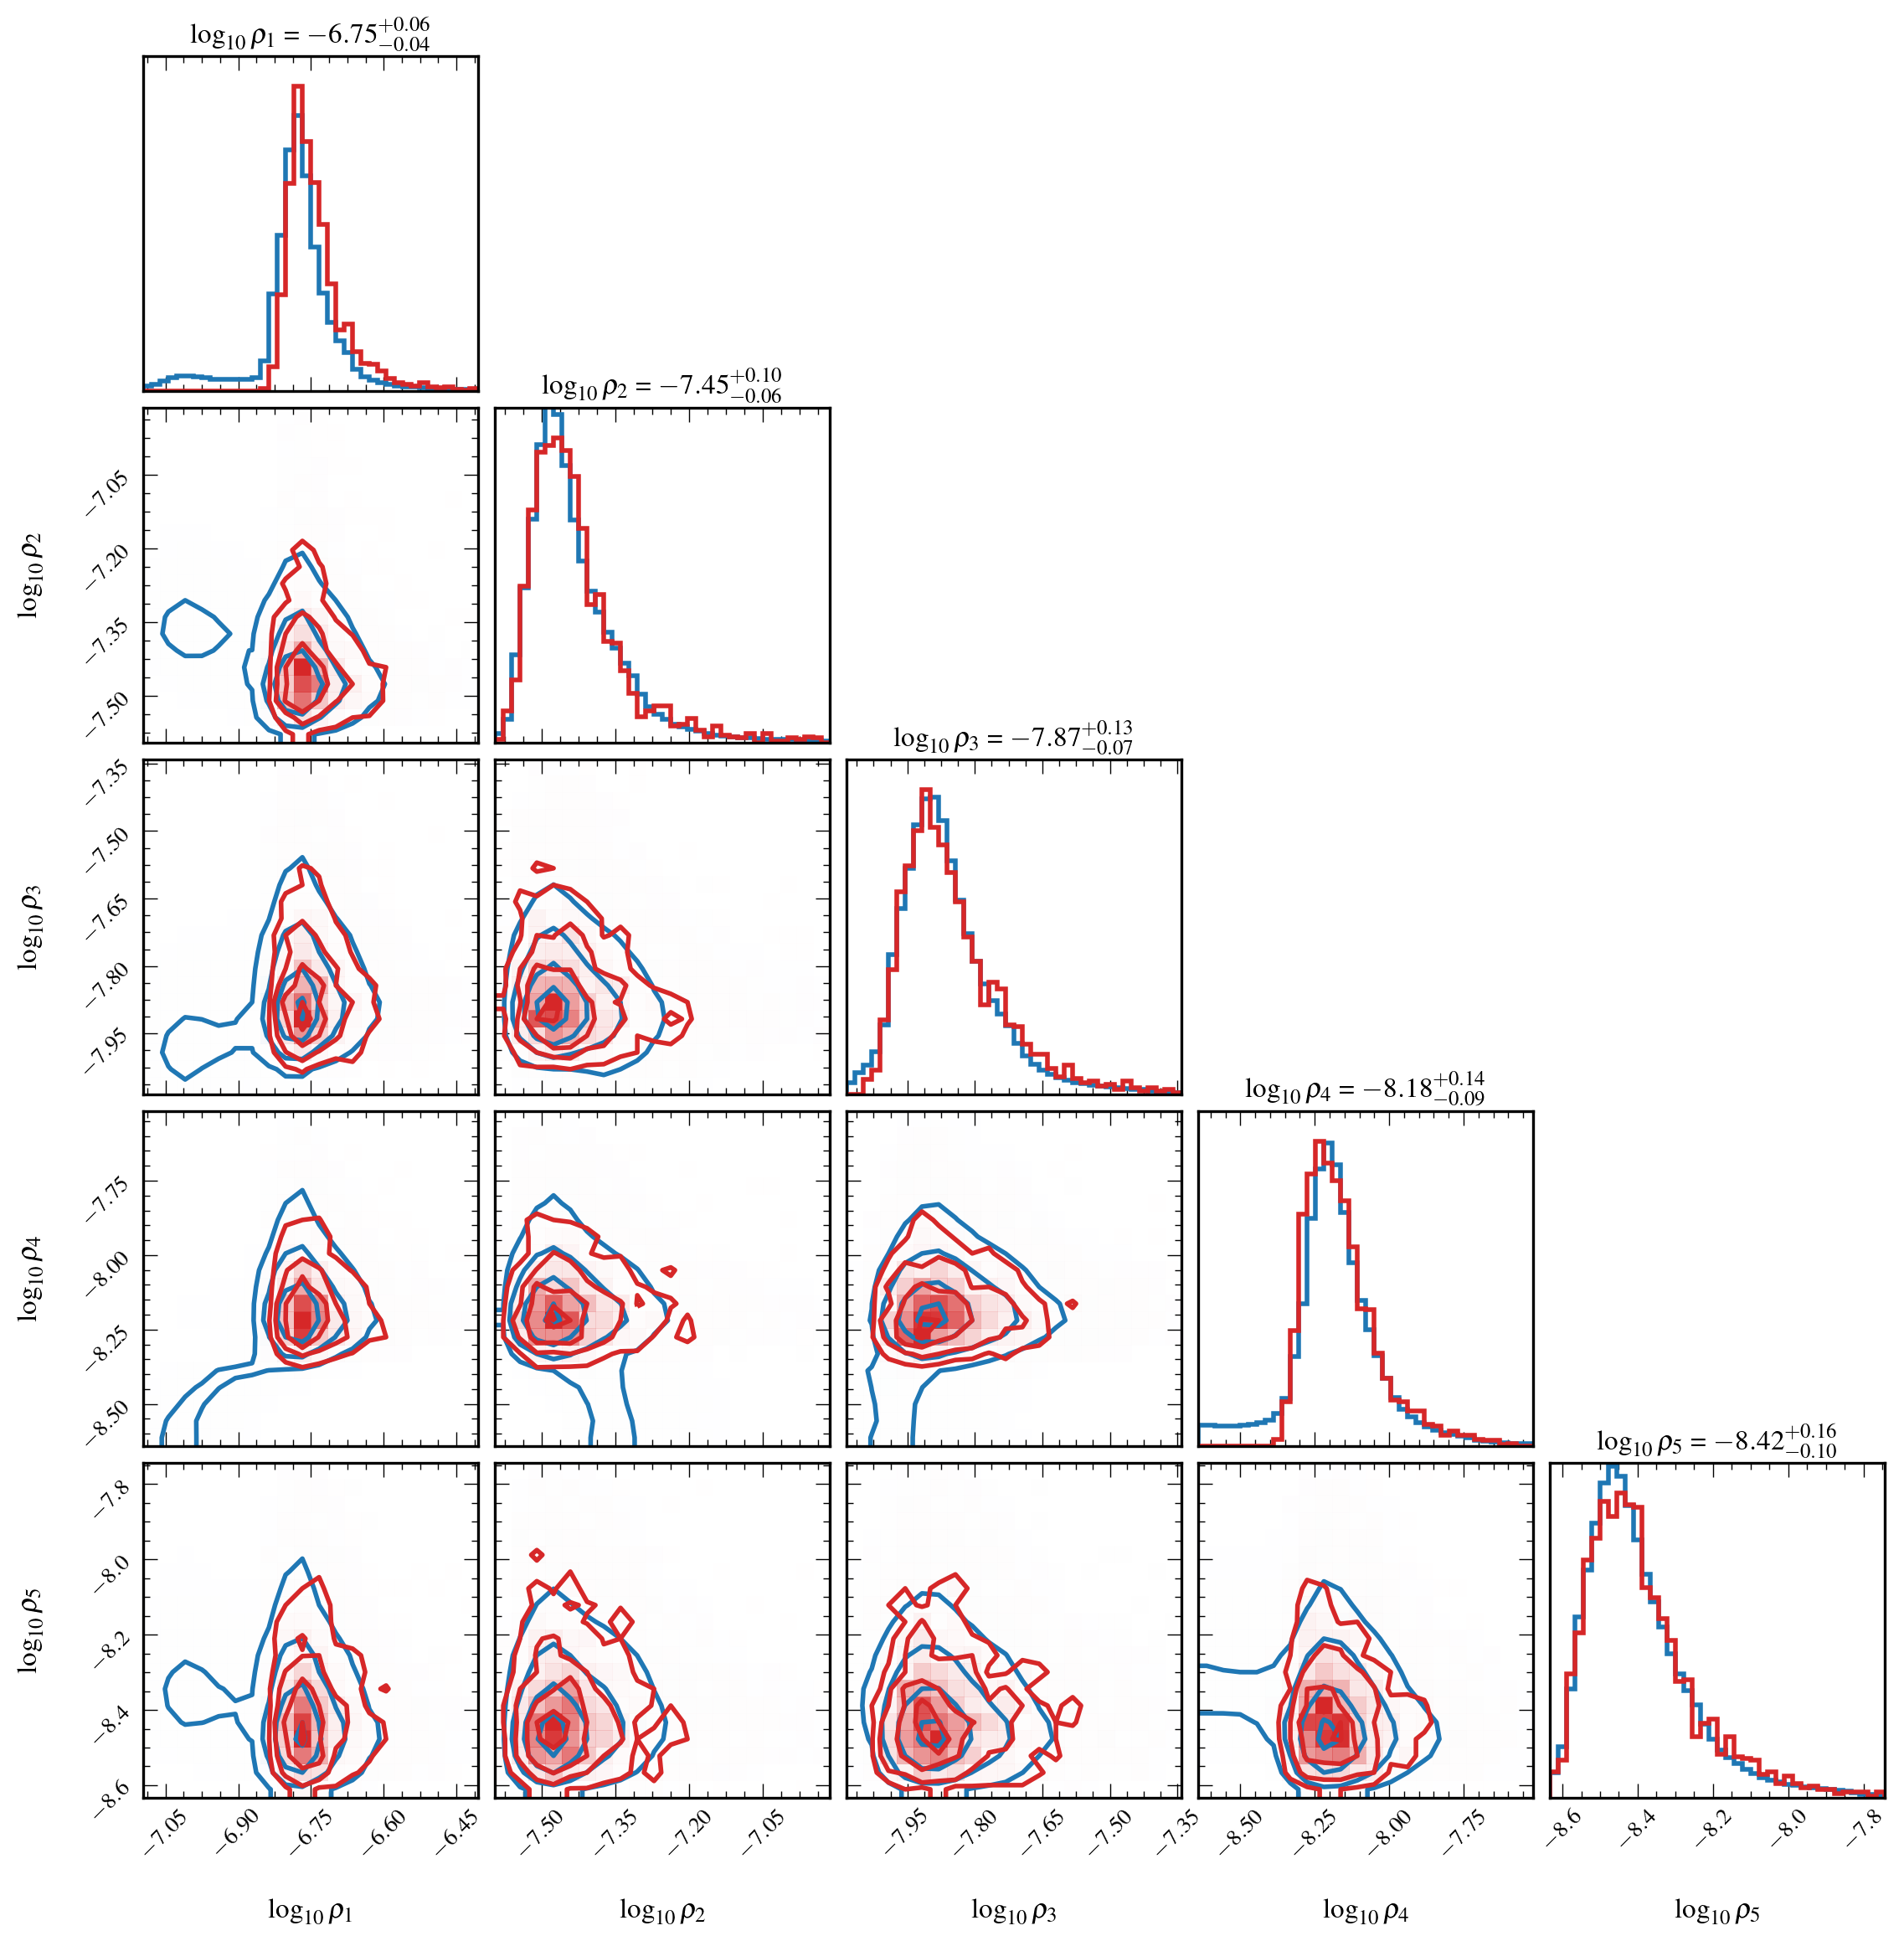

In [41]:
plt.close()

# ll = np.min(x, axis = 0)
# ul = np.max(x, axis = 0)
q = .01
ll = np.quantile(chain_train, q = q, axis = 0)
ul = np.quantile(chain_train, q = 1-q, axis = 0)
ranges = list(zip(ll, ul))
ranges

fig = None
fig = corner.corner(chain_train, color='C0', fig = fig, bins=20, hist_bin_factor=2, data_kwargs={'ms':3}, hist_kwargs={'density': True, 'lw':2}, 
                contour_kwargs={'linewidths':2}, show_titles = True, desity = True, plot_datapoints = False, range = ranges, labels = labels)

fig = corner.corner(chain_reference, fig = fig, color='C3', bins=20, hist_bin_factor=2, data_kwargs={'ms':3}, hist_kwargs={'density': True, 'lw':2}, 
                    contour_kwargs={'linewidths':2},  range = ranges, labels = labels,show_titles = True,
            truth_color = 'white', desity = True, plot_datapoints = False)

# plt.legend(handles=lg_lines, bbox_to_anchor=(0., 1.5, 1., .0), loc=4)
#plt.savefig('./Images/A4Cast/corner/5bins/corner_{}{}{}.png'.format(fidx, rr, pidx))
#plt.close()
plt.show()

## How about all of them?

In [44]:
chain_train = torch.zeros_like(chain)
chain_train[..., 0:context_dim] = chain[..., 0:context_dim]
for ct in range(chain.shape[0]):
    chain_train[ct, :, context_dim:] = rho_flow_dist.condition(chain_train[ct, 0, 0:context_dim]).sample((chain.shape[0],))
chain_train = chain_train.cpu().detach().numpy()
chain_train = chain_train* half_range/B + mean

In [45]:
chain_reference = chain.cpu().detach().numpy() * half_range/B + mean

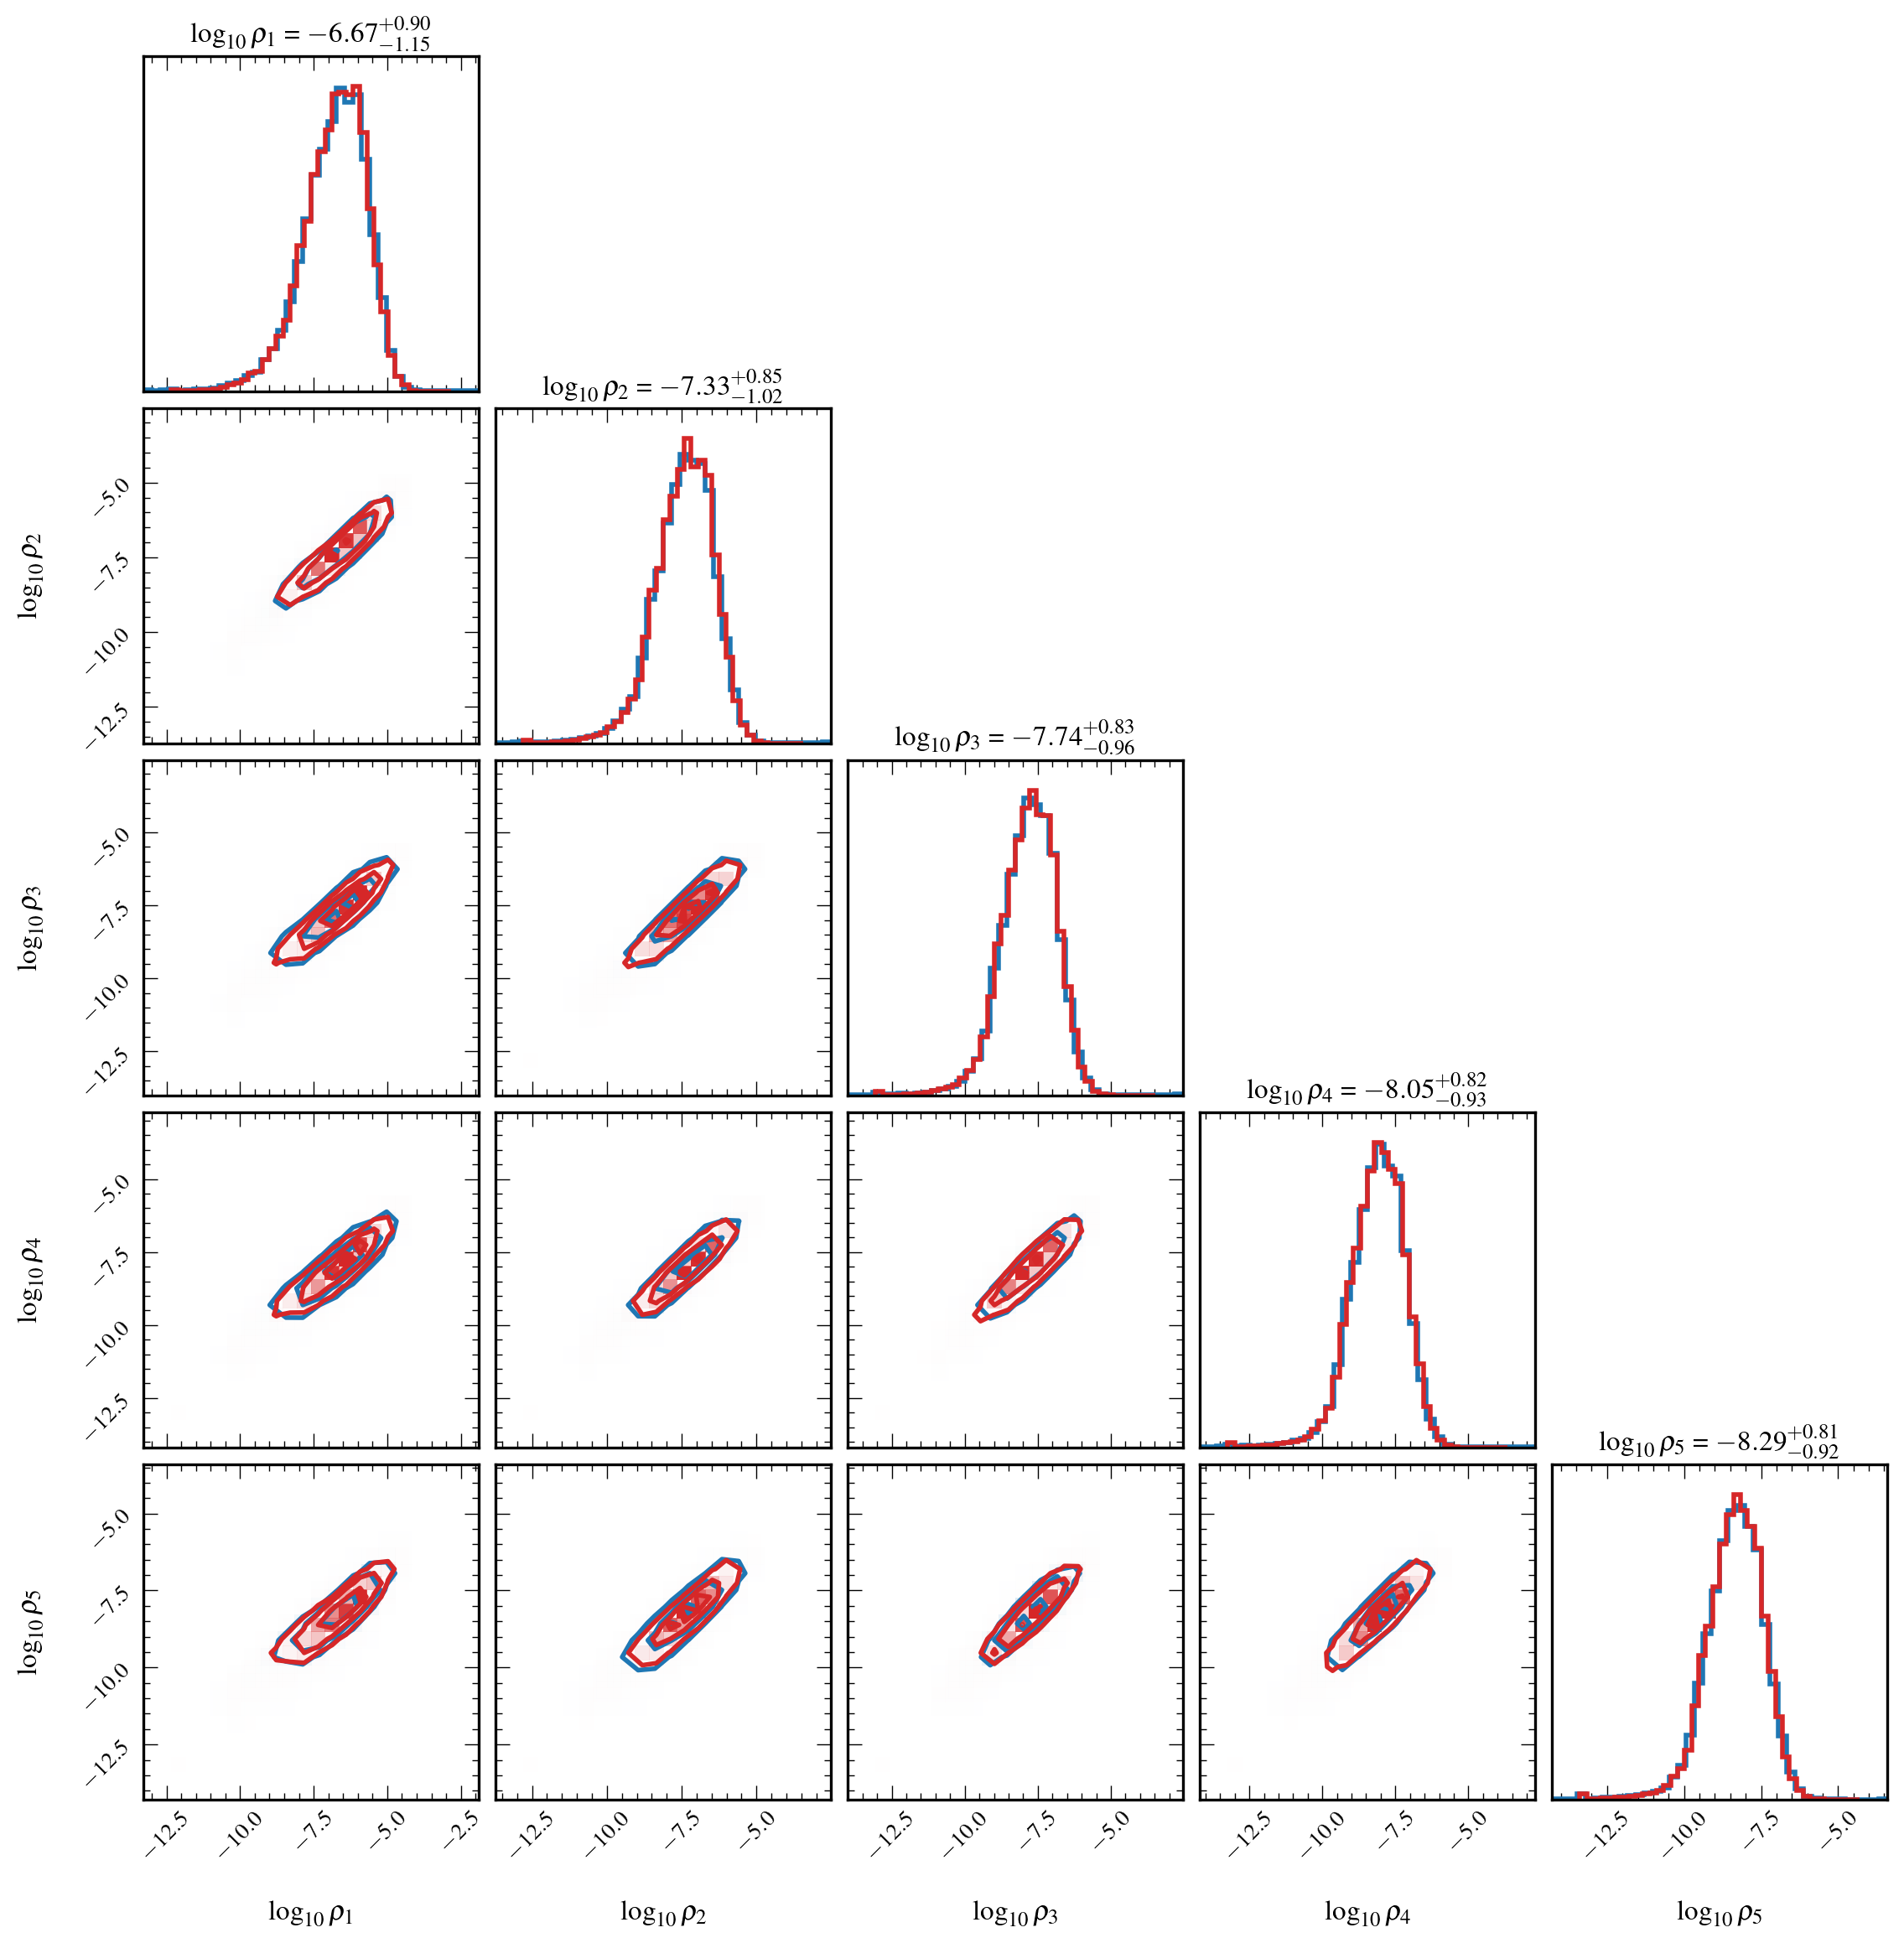

In [46]:
plt.close()
fig = None
fig = corner.corner(chain_train[:, :, -gwb_freq_bins:].reshape(chain.shape[0]*chain.shape[1], gwb_freq_bins), color='C0', 
              fig = fig, bins=20, hist_bin_factor=2, data_kwargs={'ms':3}, hist_kwargs={'density': True, 'lw':2}, 
                contour_kwargs={'linewidths':2}, show_titles = True, desity = True, plot_datapoints = False, ranges = ranges, labels = labels,)

fig = corner.corner(chain_reference[:, :, -gwb_freq_bins:].reshape(chain.shape[0]*chain.shape[1], gwb_freq_bins), color='C3', 
                    bins=20, hist_bin_factor=2, data_kwargs={'ms':3}, hist_kwargs={'density': True, 'lw':2}, fig = fig,
                    contour_kwargs={'linewidths':2}, show_titles = True, labels = labels,
            truth_color = 'white', desity = True, plot_datapoints = False)
# plt.legend(handles=lg_lines, bbox_to_anchor=(0., 1.5, 1., .0), loc=4)
#plt.savefig('./Images/A4Cast/corner/5bins/corner_{}{}{}.png'.format(fidx, rr, pidx))
#plt.close()
plt.show()

# GP Vs NF

In [11]:
from holodeck.gps.gp_utils import *

In [7]:
# rho_flow_dist, half_range, B, mean = torch.load(f'../Data/AstroData/condflow_RIGHT_2nd.pkl', map_location = 'cuda')
rho_flow_dist, half_range, B, mean = torch.load(f'../Data/AstroData/condflow_ALOT_MORE.pkl', map_location = 'cuda')

## GP preparation

In [12]:
with open('../Data/AstroData/gp_std.pkl', 'rb') as fin:
    gp_std = pickle.load(fin)

with open('../Data/AstroData/gp_med.pkl', 'rb') as fin:
    gp_med = pickle.load(fin)

gp_list_variance = set_up_predictions(spectra = None, gp_george = gp_std)
gp_list_med = set_up_predictions(spectra = None, gp_george = gp_med)

def GP(x0, gp_list_variance, gp_list_med, freqs, Tspan, draws, return_strain = True):
    hc, _, log10h2cf_sigma = hc_from_gp(gp_george = gp_med, 
                                    gp_list = gp_list_med , 
                                    gp_george_variance = gp_std, 
                                    gp_list_variance = gp_list_variance,
                                    env_pars = x0)

    log10h2cf_sigma = log10h2cf_sigma[:, 1]  # uncertainty on log10h2cf
    log10rho_sigma = (0.5*log10h2cf_sigma)[:, None]
    # Convert Zero-Mean to Characteristic Strain Squared
    h2cf = hc**2
    # turn predicted h2cf to psd/T to log10_rho
    psd = h2cf/(12*np.pi**2 * freqs**3 * Tspan)
    log10_rho_gp = 0.5*np.log10(psd)[:, None]
    
    return np.random.default_rng().multivariate_normal(log10_rho_gp.flatten(), np.diag(log10rho_sigma.flatten()), draws)

In [9]:
# rand_idx = random.randint(0, chain.shape[0] - 1)
# rand_idx = 87
rand_idx = 1313

In [10]:
# x0 = np.array([0.5, -1.75, 11.5, 8, .1, -.4])
x0 = chain[rand_idx, 0, :-crn_bins].cpu().detach().numpy() * half_range[: -crn_bins]/B + mean[: -crn_bins]
x0

NameError: name 'chain' is not defined

In [106]:
hc, _, log10h2cf_sigma = hc_from_gp(gp_george = gp_med, 
                                   gp_list = gp_list_med , 
                                   gp_george_variance = gp_std, 
                                   gp_list_variance = gp_list_variance,
                                   env_pars = x0)

log10h2cf_sigma = log10h2cf_sigma[:, 1]  # uncertainty on log10h2cf
log10rho_sigma = (0.5*log10h2cf_sigma)[:, None]
# Convert Zero-Mean to Characteristic Strain Squared
h2cf = hc**2

# turn predicted h2cf to psd/T to log10_rho
psd = h2cf/(12*np.pi**2 * freqs**3 * Tspan)
log10_rho_gp = 0.5*np.log10(psd)[:, None]

gp_rhos = np.random.default_rng().multivariate_normal(log10_rho_gp.flatten(), np.diag(log10rho_sigma.flatten()), int(1e5))

In [107]:
def rho_to_strain(rho, freqs, Tspan):
    return np.sqrt(10**(2 * rho) * (12*np.pi**2 * freqs**3 * Tspan))

In [108]:
hc

array([3.81888528e-15, 2.12863343e-15, 1.48497739e-15, 1.12762507e-15,
       9.02253634e-16])

In [109]:
log10_rho_gp, log10rho_sigma

(array([[-6.75077243],
        [-7.45615316],
        [-7.87667108],
        [-8.1836343 ],
        [-8.42583541]]),
 array([[0.07283623],
        [0.10562136],
        [0.13353998],
        [0.14554645],
        [0.16128302]]))

## Generate samples from the flow

In [96]:
x0_transformed = (x0 - mean[:-crn_bins]) * B/half_range[:-crn_bins]
context = torch.tensor(x0_transformed, device = 'cuda', dtype=torch.float32)
nf_rhos = (rho_flow_dist.condition(context).sample((int(1e5),)).detach().cpu().numpy() * half_range[-crn_bins:]/B) + mean[-crn_bins:]

## Actual library data

In [97]:
from_lib = chain[rand_idx, :, -crn_bins:].cpu().detach().numpy() * half_range[-crn_bins:]/B + mean[-crn_bins:]
from_lib.shape

(2000, 5)

In [98]:
# for fidx in range(crn_bins):
#     plt.title(f'Frequency {fidx+1}/Tspan')
#     plt.hist(nf_rhos[:, fidx], **hist_settings, color = 'gold', label = 'from NF')
#     plt.hist(gp_rhos[:, fidx], **hist_settings, color = 'white', label = 'from GP')
#     plt.hist(from_lib[:, fidx], color = 'lawngreen', **hist_settings, label = 'from phenom library')
#     plt.xlabel('log10rho')
#     plt.ylabel('PDF')
#     plt.show()

In [102]:
lg_lines = []
lg_lines.append(mlines.Line2D([], [], color='C0', label=f'from NF'))
lg_lines.append(mlines.Line2D([], [], color='C1', label=f'from GP'))
lg_lines.append(mlines.Line2D([], [], color='C3', label=f'from phenom library\n env_params = {x0}'))

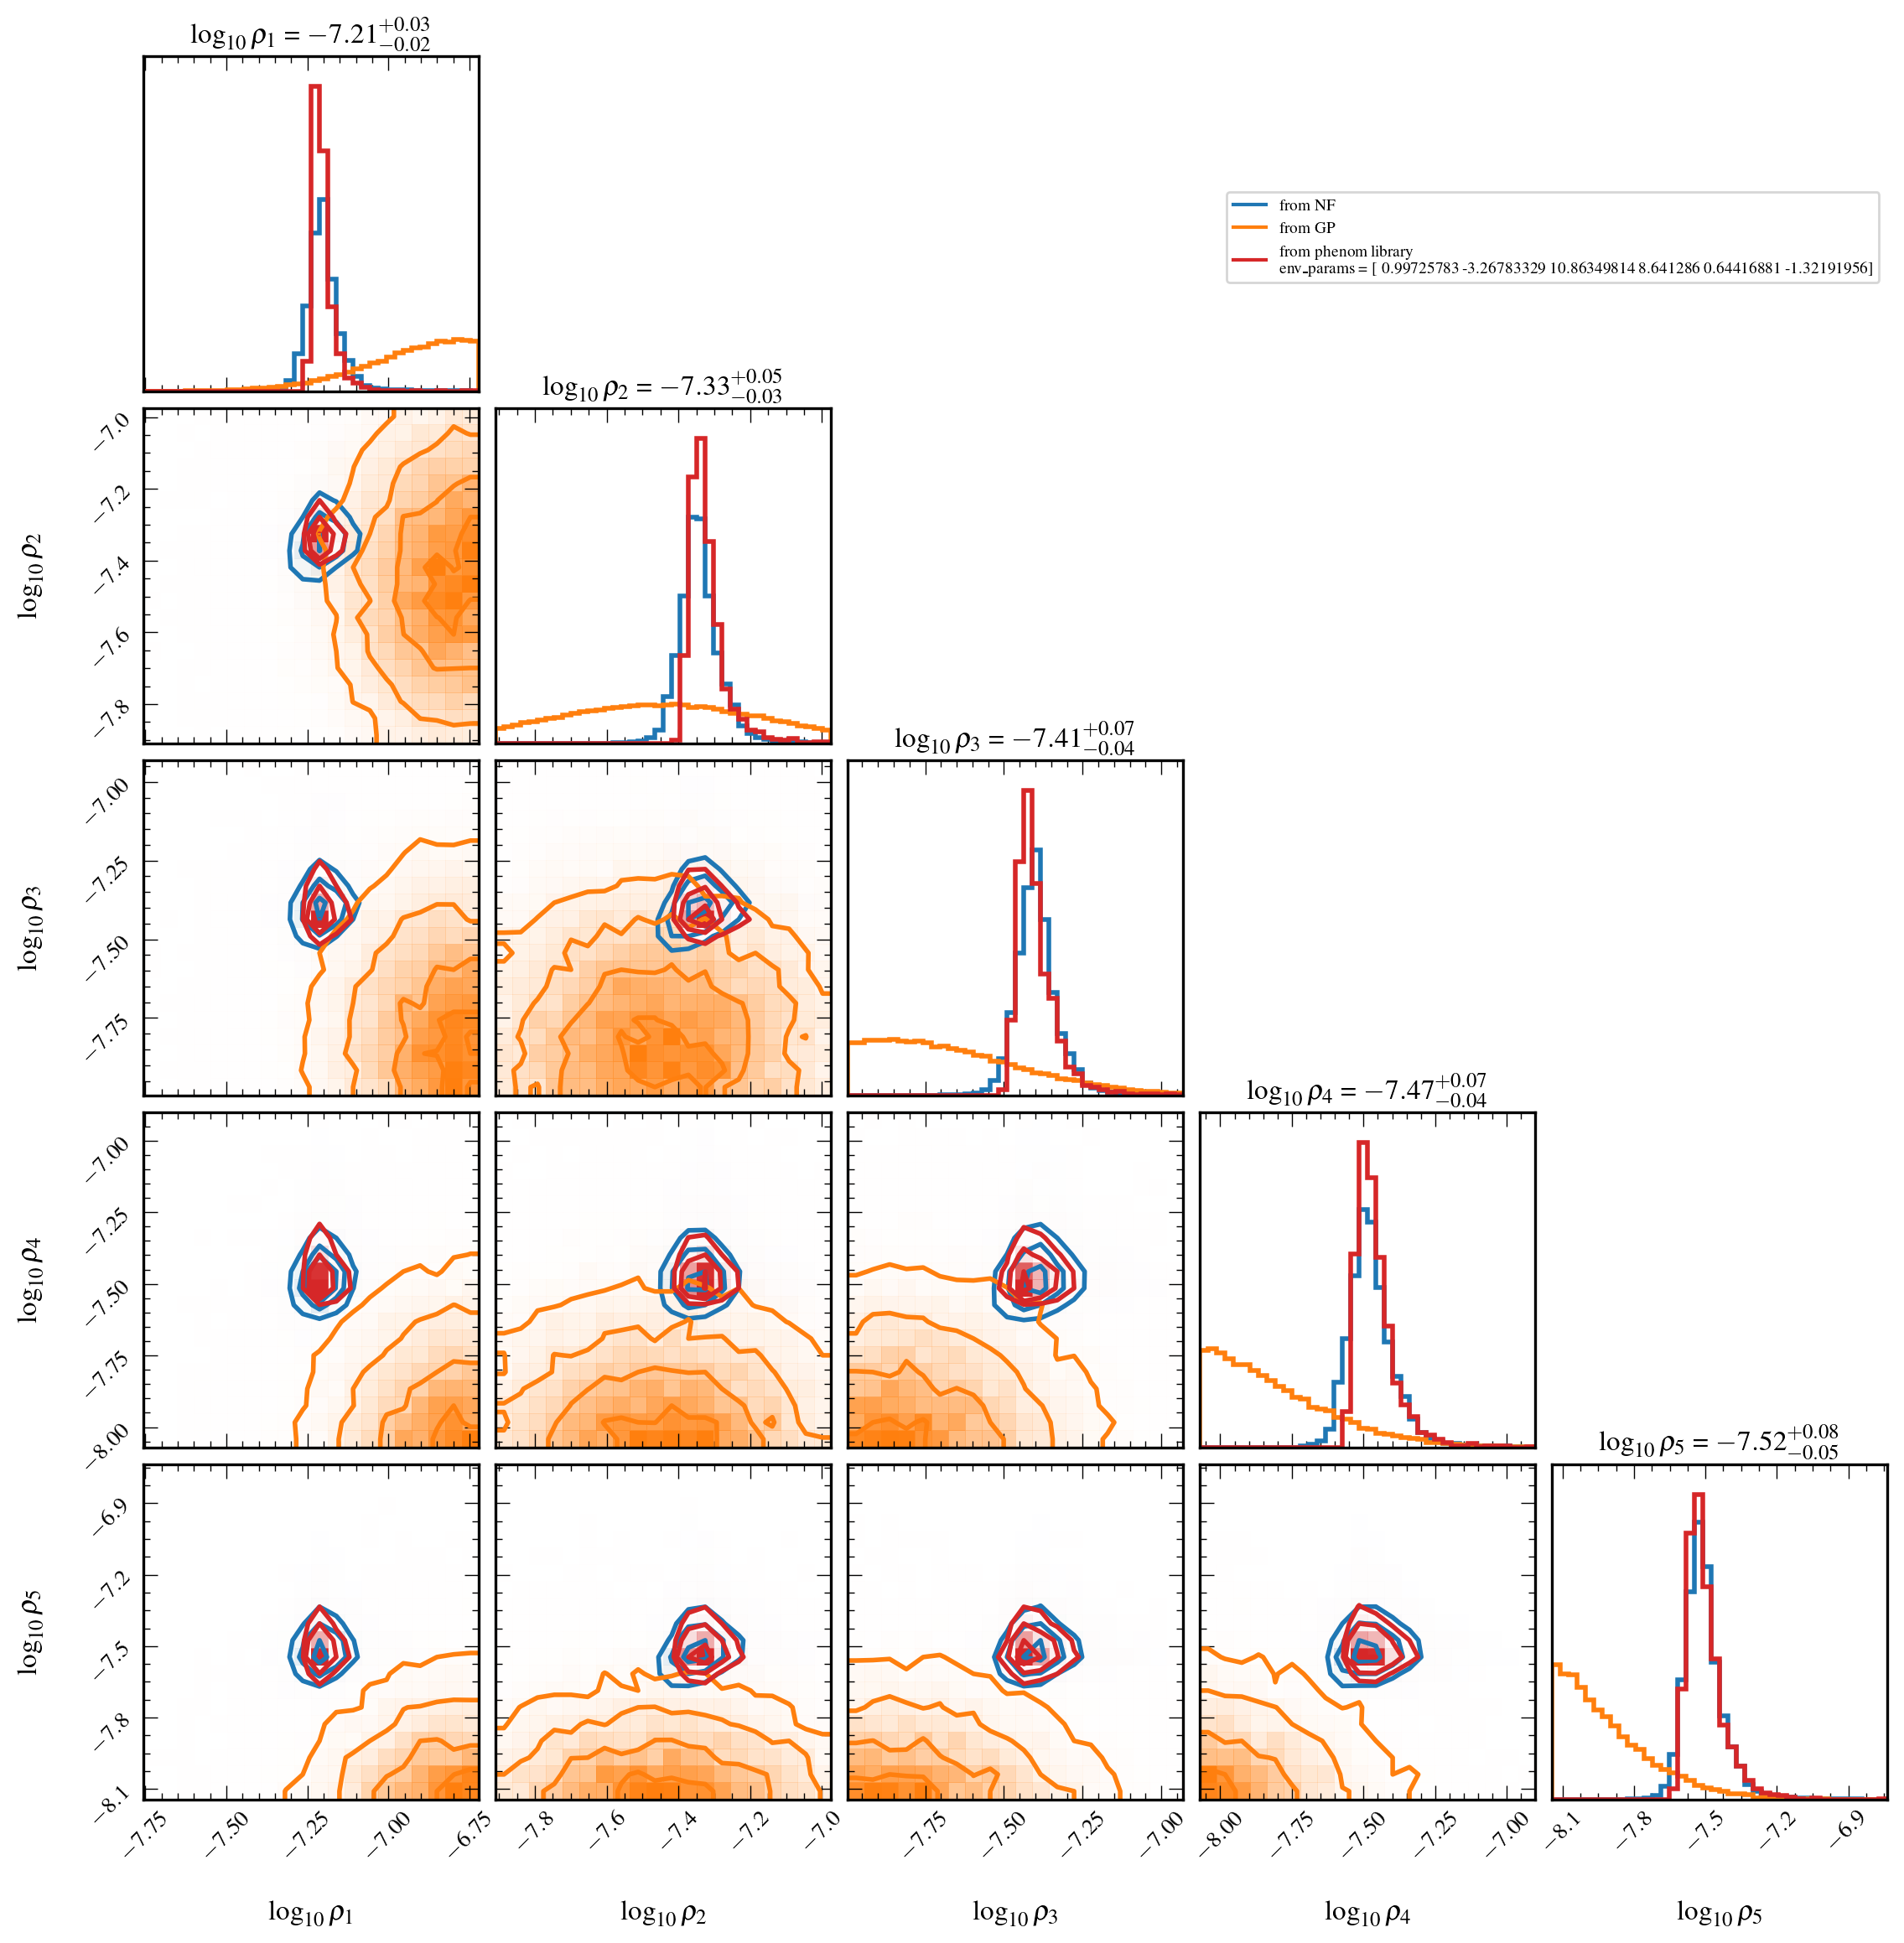

In [110]:
plt.close()
ll = np.min(from_lib, axis = 0)
ul = np.max(from_lib, axis = 0)
ranges = list(zip(ll - .5, ul))

fig = None
fig = corner.corner(nf_rhos, fig = fig,
                    color='C0', bins=20, hist_bin_factor=2, data_kwargs={'ms':3}, hist_kwargs={'density': True, 'lw':2}, range = ranges,
                    contour_kwargs={'linewidths':2}, 
            truth_color = 'white', desity = True, plot_datapoints = False)

fig = corner.corner(gp_rhos, fig = fig,
                    color='C1', bins=20, hist_bin_factor=2, data_kwargs={'ms':3}, hist_kwargs={'density': True, 'lw':2}, range = ranges,
                    contour_kwargs={'linewidths':2}, 
            truth_color = 'white', desity = True, plot_datapoints = False)

fig = corner.corner(from_lib, fig = fig,
                    color='C3', bins=20, hist_bin_factor=2, data_kwargs={'ms':3}, hist_kwargs={'density': True, 'lw':2}, range = ranges,
                    contour_kwargs={'linewidths':2}, labels = labels, show_titles=True,
            truth_color = 'white', desity = True, plot_datapoints = False)

plt.legend(handles=lg_lines, bbox_to_anchor=(0., 4.5, 1., .0), loc=4)
plt.show()

In [71]:
# gwb = chain[:, :, -crn_bins:].cpu().detach().numpy().reshape(chain.shape[0]*chain.shape[1], crn_bins) * half_range[-crn_bins:]/B + mean[-crn_bins:]
# gwb = chain_train[87, :, -crn_bins:].cpu().detach().numpy() * half_range[-crn_bins:]/B + mean[-crn_bins:]
gwb = x * half_range[-crn_bins:]/B + mean[-crn_bins:]
gwb.shape

(1000000, 5)

In [72]:
gwb = 10**(gwb * 2)
gwb

array([[2.80300508e-15, 2.04734431e-15, 1.62116538e-15, 1.31219720e-15,
        9.51229227e-16],
       [3.28699652e-15, 2.64856827e-15, 1.52838668e-15, 1.11641828e-15,
        7.72716657e-16],
       [4.17146027e-15, 2.46282662e-15, 2.28471161e-15, 1.77549718e-15,
        2.74613415e-15],
       ...,
       [3.82705052e-15, 2.06628677e-15, 1.56920698e-15, 1.05424938e-15,
        9.97859802e-16],
       [4.17151572e-15, 1.85844525e-15, 1.34791504e-15, 8.75174127e-16,
        7.37125789e-16],
       [3.45606302e-15, 2.12225656e-15, 1.68559203e-15, 9.94294064e-16,
        9.81297715e-16]])

In [73]:
gwb.shape

(1000000, 5)

In [74]:
freqs

array([1.97682646e-09, 3.95365292e-09, 5.93047937e-09, 7.90730583e-09,
       9.88413229e-09])

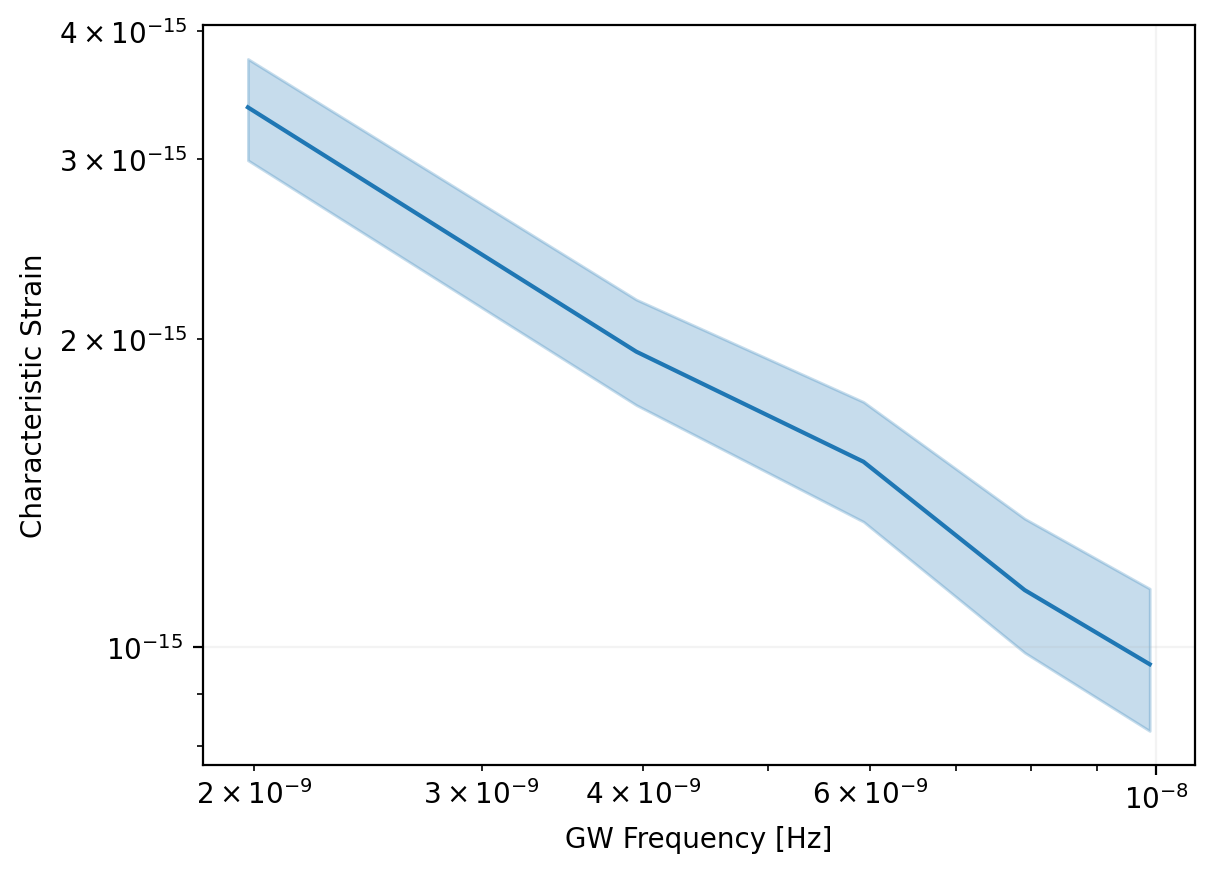

In [75]:
fig, ax = plt.subplots()

med = np.median(gwb, axis=0)
conf = np.percentile(gwb, [25, 75], axis=0)
ax.set(xscale='log', xlabel='GW Frequency [Hz]', yscale='log', ylabel='Characteristic Strain')
ax.grid(True, alpha=0.15)
xx = freqs
cc, = ax.plot(xx, med)
cc = cc.get_color()
ax.fill_between(xx, *conf, color=cc, alpha=0.25)

# ax.plot(xx, gwb, color='0.5', alpha=0.5, lw=0.5)


# xticks = [2, 5, 10, 20, 50]
# ax.set_xticks(xticks, xticks)

plt.show()

In [76]:
# rand_idx = random.randint(0, chain.shape[0] - 1)
rand_idx = 1313
rand_idx

1313

In [77]:
rand_idx = random.randint(0, chain.shape[0] - 1)
# rand_idx = 1313
rand_idx

86

In [78]:
x = rho_flow_dist.condition(chain[rand_idx, 0, 0:context_dim]).sample((int(1e6),)).cpu().detach().numpy()

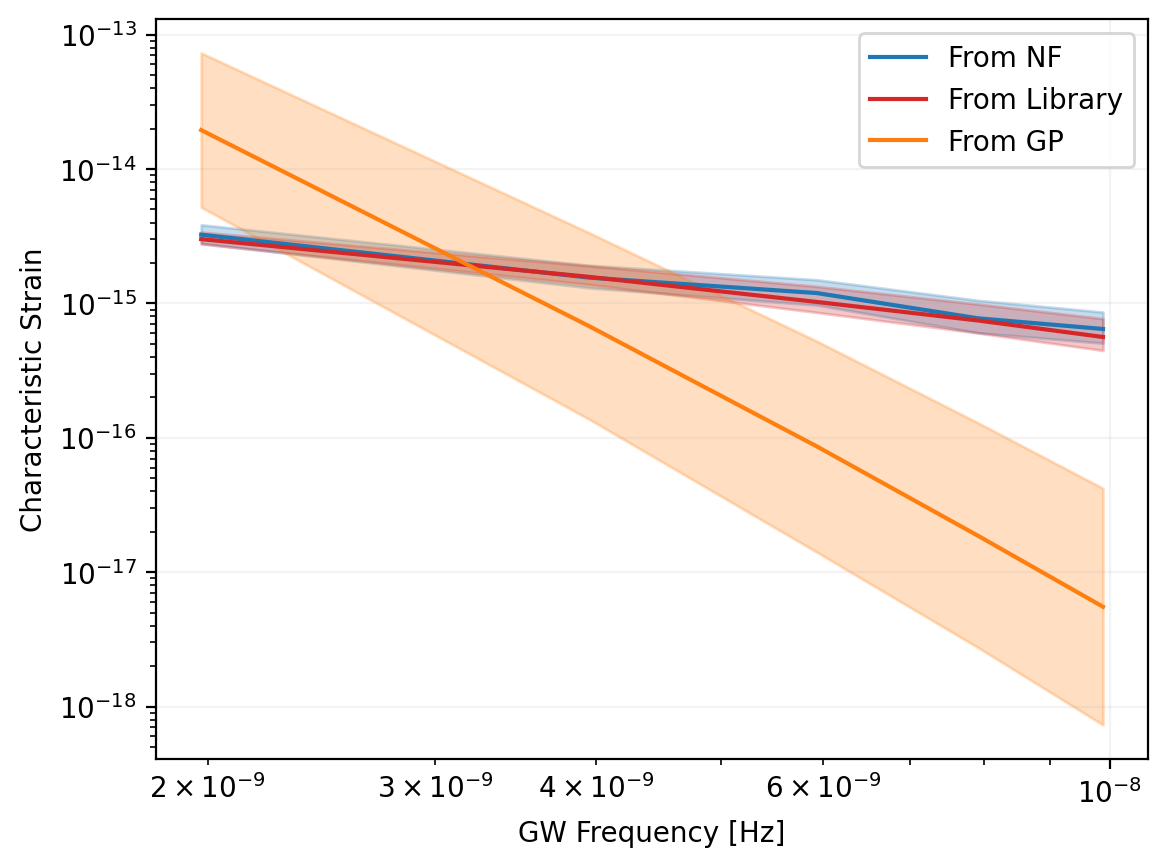

In [79]:
fig, ax = plt.subplots()

##############################################################from NF##############################################################
gwb = x * half_range[-crn_bins:]/B + mean[-crn_bins:]
gwb = 10**(gwb * 2)
med = np.median(gwb, axis=0)
conf = np.percentile(gwb, [25, 75], axis=0)
ax.set(xscale='log', xlabel='GW Frequency [Hz]', yscale='log', ylabel='Characteristic Strain')
ax.grid(True, alpha=0.15)
xx = freqs
cc, = ax.plot(xx, med, label = 'From NF')
cc = cc.get_color()
ax.fill_between(xx, *conf, color=cc, alpha=0.25)

del gwb
del med
del conf

##############################################################from Library##############################################################
gwb = chain[rand_idx, :, -crn_bins:].cpu().detach().numpy() * half_range[-crn_bins:]/B + mean[-crn_bins:]
gwb = 10**(gwb * 2)
gwb.shape
med = np.median(gwb, axis=0)
conf = np.percentile(gwb, [25, 75], axis=0)
ax.set(xscale='log', xlabel='GW Frequency [Hz]', yscale='log', ylabel='Characteristic Strain')
ax.grid(True, alpha=0.15)
xx = freqs
cc, = ax.plot(xx, med, color = 'C3', label = 'From Library')
cc = cc.get_color()
ax.fill_between(xx, *conf, color='C3', alpha=0.25)

del gwb
del med
del conf

##############################################################from GP##############################################################
x0 = chain[rand_idx, 0, :-crn_bins].cpu().detach().numpy() * half_range[:-crn_bins]/B + mean[:-crn_bins]
hc, _, log10h2cf_sigma = hc_from_gp(gp_george = gp_med, 
                                   gp_list = gp_list_med , 
                                   gp_george_variance = gp_std, 
                                   gp_list_variance = gp_list_variance,
                                   env_pars = x0)

log10h2cf_sigma = log10h2cf_sigma[:, 1]  # uncertainty on log10h2cf

# Convert Zero-Mean to Characteristic Strain Squared
h2cf = hc**2

# turn predicted h2cf to psd/T to log10_rho
psd = h2cf/(12*np.pi**2 * freqs**3 * Tspan)
log10_rho_gp = 0.5*np.log10(psd)[:, None]

gwb = np.random.default_rng().multivariate_normal(log10_rho_gp.flatten(), np.diag(log10h2cf_sigma), int(1e5))

gwb = 10**(gwb * 2)
gwb.shape
med = np.median(gwb, axis=0)
conf = np.percentile(gwb, [25, 75], axis=0)
ax.set(xscale='log', xlabel='GW Frequency [Hz]', yscale='log', ylabel='Characteristic Strain')
ax.grid(True, alpha=0.15)
xx = freqs
cc, = ax.plot(xx, med, color = 'C1', label = 'From GP')
cc = cc.get_color()
ax.fill_between(xx, *conf, color='C1', alpha=0.25)

plt.legend()
# ax.plot(xx, gwb, color='0.5', alpha=0.5, lw=0.5)


# xticks = [2, 5, 10, 20, 50]
# ax.set_xticks(xticks, xticks)

plt.show()

# Bayesian parameter inference of astro params with Normalizing Flows

## Load the flow as a cpu-mapped python object 

In [82]:
# crn_bins = 10

In [48]:
# NF = torch.load('../Data/AstroData/condflow_RIGHT.pkl', map_location = 'cpu')

In [49]:
# NF

### Speed test! CPU Vs GPU

### GPU

In [ ]:
context = chain_train[100, 0:context_dim]

NameError: name 'chain_train' is not defined

In [ ]:
%timeit rho_flow_dist.condition(context).sample((1,))

1.21 ms ± 6.93 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
%timeit rho_flow_dist.condition(context).sample((1000,))

1.23 ms ± 14 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### CPU

In [ ]:
context = chain_train[100, 0:context_dim].cpu().detach()

In [ ]:
%timeit NF[0].condition(context).sample((1,))

737 µs ± 21.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
%timeit NF[0].condition(context).sample((1000,))

1.46 ms ± 33.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
NF[0].condition(context).sample((1000,)).shape

torch.Size([1000, 5])

## Ceffyl Object

In [2]:
import ceffyl
import ceffyl.ceffyl_gp as cg

Optional mpi4py package is not installed.  MPI support is not available.


In [3]:
from enterprise.signals import parameter

In [4]:
# rho_flow_dist, half_range, B, mean = torch.load(f'../Data/AstroData/condflow_RIGHT_2nd_more.pkl', map_location = 'cuda')

In [5]:
# param_names, B

In [6]:
params = ['hard_time',
'gsmf_phi0',
'gsmf_mchar0_log10',
'mmb_mamp_log10',
'mmb_scatter_dex',
'hard_gamma_inner']

In [7]:
truths = np.array([ 7.62491879, -2.17841798, 11.60346952,  8.41323926,  0.64659339,
        -0.97838986])

In [8]:
hyperparams = []
# for lb, ub, p in zip(par_data.min(axis = (0, 1)), par_data.max(axis = (0, 1)), params):
#     hyperparams.append(parameter.Uniform(lb, ub)(p))
# hyperparams
hyperparams.append(parameter.Uniform(0.10069627107013876, 10.996444433046685)(params[0]))
for val, p in zip(truths[1:], params[1:]):
    hyperparams.append(parameter.Constant(val)(p))
hyperparams

[hard_time:Uniform(pmin=0.10069627107013876, pmax=10.996444433046685),
 gsmf_phi0:Constant=-2.17841798,
 gsmf_mchar0_log10:Constant=11.60346952,
 mmb_mamp_log10:Constant=8.41323926,
 mmb_scatter_dex:Constant=0.64659339,
 hard_gamma_inner:Constant=-0.97838986]

In [57]:
# np.save('../ChainPaper/ASTROSIM/freqs.npy', freqs)

In [14]:
crn_bins = 5

In [15]:
m = cg.ceffylGP(datadir = '../ChainPaper/ASTROSIM/',
                #../Data/AstroData/ceffyl_data/30f_fs{hd}_ceffyl', #'../Data/AstroData/ceffyl_data/30f_fs{hd+mp+dp+cp}_ceffyl_hd-only',
            hyperparams = hyperparams, 
            gp = gp_list_med, 
            gp_george = gp_med, 
            var_gp = gp_list_variance,
            var_gp_george = gp_std, 
            spectrum=None, 
            Nfreqs=crn_bins, 
            freq_idxs=None,
            mean_params = None,
            half_range_params=None,
            B = None,
            NF = None,
            log10_rho_priors=[-10, -6])

In [16]:
m.const_values

array([-2.17841798, 11.60346952,  8.41323926,  0.64659339, -0.97838986])

In [17]:
x0 = np.hstack([p.sample() for p in hyperparams[0:1]])
x0

array([4.47096962])

In [18]:
%timeit m.ln_likelihood(x0)

46.1 ms ± 776 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
half_range_rho = half_range[-crn_bins:]
mean_rho = mean[-crn_bins:]

In [28]:
grid = (m.rho_grid - mean_rho[:, None]) * B/half_range_rho[:, None]
grid.shape

(5, 10000)

In [29]:
grid = torch.tensor(grid, device = 'cuda', dtype=torch.float32)

In [31]:
# oo = NF[0].condition(context)
# logprob = oo.log_prob(grid.T)
# logprob 

In [32]:
# good_idxs = np.argwhere(np.isfinite(logprob.detach().numpy()))

In [33]:
# context * half_range[:-crn_bins]/B + mean[:-crn_bins]

In [30]:
m.rho_grid_pytensor = grid

In [31]:
# x0 = np.array([0.5, -1.75, 11.5, 8, .1, -4])

In [32]:
m.ln_nflikelihood(x0)

-21.918850847118737

In [101]:
%timeit m.ln_nflikelihood(x0)

14.7 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%timeit m.ln_prior(x0)

4.19 µs ± 59.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


# MCMC Sampling

In [20]:
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

In [21]:
# parameter groupings for better sampling
groups = [np.arange(len(m.param_names))]

cov = np.identity(len(x0))*0.01

sampler = ptmcmc(len(x0), logl=m.ln_likelihood,
                    logp=m.ln_prior, cov=cov, groups=groups,
                    outDir=f'../ChainPaper/ASTROSIM/GP/', resume=False)

In [22]:
m.param_names

['hard_time']

In [23]:
jp = cg.JumpProposal(m)
sampler.addProposalToCycle(jp.draw_from_prior, 10)
sampler.addProposalToCycle(jp.draw_from_env_prior, 20)

if np.any(['hard' in par for par in m.param_names]):
    sampler.addProposalToCycle(jp.draw_from_hard_prior, 10)

if np.any(['gsmf' in par for par in m.param_names]):
    sampler.addProposalToCycle(jp.draw_from_gsmf_prior, 10)

if np.any(['gpf' in par for par in m.param_names]):
    sampler.addProposalToCycle(jp.draw_from_gpf_prior, 10)

if np.any(['gmt' in par for par in m.param_names]):
    sampler.addProposalToCycle(jp.draw_from_gmt_prior, 10)

if np.any(['mmb' in par for par in m.param_names]):
    sampler.addProposalToCycle(jp.draw_from_mmb_prior, 10)

In [24]:
N = int(1e6)
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

/home/nima/anaconda3/envs/ent/lib/python3.9/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 1.00 percent in 455.482446 s Acceptance rate = 0.397633Adding DE jump with weight 50
Finished 99.90 percent in 47280.489026 s Acceptance rate = 0.474108
Run Complete
